# How to use this notebook

This notebook contains cells which can be run to train, evaluate and visualise certain models, under certain evaluation settings. These cells are organised in a way so that a user can run all the code cells, and then execute the specific cell which trains/retrains the model they want to train. These models are then saved to a save path specific to the evaluatation setting used, meaning the model can then be used with my_infer.py or our web-based UI.

Section **"Train, Evaluate and Visualise"** features cells which train, evaulate and then visualise the keyshot predictions of the model trained. This model is also saved.

Section **"Train and Evaluate"** features cells which train and evaluate model(s). This model is also saved. These cells contain calls to train models under specific training parameters, containing most of the model parameter combinations we chose in our report (and hence the results we quote for these parameters).

The last section of the notebook, section **"Representative Frame Visualisation"**, runs some code which extracts the representative frames of the example summaries we generated for our report.


# Code

These cells need to be run before the training, evaluation and visualisation code can be executed. All cells up until the "Train, Evaluate and Visualise" section need to be run.

#### train_basic_NN()

This function is invoked by a driver training function, which tells this function which split to train on. Using the passed parameters, a model object is created, trained and evaluated on the given split. Supports or single and multi model pipeline.

See runTraining() to run your own training.

In [1]:
import logging

import torch

from basic_NN.basic_NN import BasicRNN
from basic_GRU.basic_GRU import BasicGRU

from helpers import data_helper, vsumm_helper, video_helper

from extract_features import extract_features_for_video
from helpers import init_helper

# Clustering + Classification
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# import matplotlib.cm as cms
import matplotlib.colors as mcolors

import pickle

logger = logging.getLogger()

# @Parameters:
# - split: A file path to one of the pipeline's split files
# - mode: Refers to whether the pipeline uses a single or multiple models (accepts "single" or "multi")
# - featureMode: Specify how the features for a split are computed (accepts "precomputed","train-per-split","pca")
# - base: The model base to use (accepts "RNN" or "GRU")
# - plot: If True, will plot the loss and validation F-Score over the course of training.
# - visualise + manualVisuals: Parameters to be used for visualisation in trainAndCompare()
# @Outputs:
# - Returns the best validation F-Score seen for this split alongside visualisation data
# for trainAndCompare() calls
def train_basic_NN(args, split, save_path, mode, featureMode, base="RNN", plot=False, visualise=None, manualVisuals=[]):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    max_val_fscore = -1

    train_set = data_helper.VideoDataset(split['train_keys'])
    train_loader = data_helper.DataLoader(train_set, shuffle=True)

    val_set = data_helper.VideoDataset(split['test_keys'])
    val_loader = data_helper.DataLoader(val_set, shuffle=False)

    #################### CLUSTERING PREP ####################
    
    if mode == "multi":
        
        parserInFunc = init_helper.get_parser()
        # Use a sample rate of 1, since seq is already downsampled, so taking every
        # frame of a 15 sample rate result.
        pathToVFT = "../../"

        if featureMode == "train-per-split":
            # Getting non-reduced features
            featureFormatToGet = "avg1024D"
        elif featureMode == "pca":
            # Getting non-reduced features
            featureFormatToGet = "avg1024D"
        # Features already 2D
        elif featureMode == "precomputed":
            featureFormatToGet = "avg2D"
            
        # Preparing parameters for our feature extraction call
        toPass = ["feat-anchor-free",
                  "--ckpt-path",str(pathToVFT)+"pipeline/pretrained_models/pretrain_af_basic/checkpoint/tvsum.yml.0.pt",
                  "--source","",
                  "--save-path","",
                  "--nms-thresh","0.4",
                  "--sample-rate","1",
                  # "--featureFormat","avg2D"]
                  "--featureFormat",featureFormatToGet]
        argsInFunc = parserInFunc.parse_args(toPass)

        ae2dPath = "ae2d/pretrainedAE2D.pt"

        # Collect the features for each video, and create a mapping of video_id -> features
        collectedTrainKeys = []
        collectedTrainFeatures = []
        for mappedKey, seq, _, _, _, _, _, _ in train_loader:
            collectedTrainFeatures.append( extract_features_for_video(argsInFunc,seq,prints=False,returnFeats=True,ae2dPath=ae2dPath) )
            collectedTrainKeys.append(mappedKey)
    
        # In these cases, we need to additionally reduce the features to 2D
        if featureMode == "train-per-split":
            collectedTrainFeatures = np.asarray(collectedTrainFeatures,dtype="float32").squeeze()
            # Train auto encoder on this split's training data
            trained_ae_model, _ = trainAE(collectedTrainFeatures)
            collectedTrainFeatures = runAE(collectedTrainFeatures, trained_ae_model)
        elif featureMode == "pca":
            collectedTrainFeatures = np.asarray(collectedTrainFeatures).squeeze()
            # Convert to 2D using PCA
            pca_transformer = PCA(n_components=2)
            pca_transformer.fit(collectedTrainFeatures)
            collectedTrainFeatures = pca_transformer.transform(collectedTrainFeatures)
            
        print("Number of Training Features to cluster for this split: " + str(len(collectedTrainFeatures)))
        print("Feature Shape:",collectedTrainFeatures[0].shape)
        print("Number of Training Keys:",len(collectedTrainKeys))

        # Clustering

        # DBSCAN
        # db = DBSCAN(eps=0.15, min_samples=5).fit(collectedTrainFeatures)
        # labels = db.labels_
        # n_clusters = len(set(labels)) - (1 if -1 in labels_db else 0)

        # KMeans
        KM_model = KMeans(n_clusters=2)
        km = KM_model.fit(collectedTrainFeatures)
        labels = km.labels_
        n_clusters = KM_model.n_clusters

        classes = np.unique(labels)
        print("Number of clusters:",n_clusters)

        # Create mapping from collectedTrainKeys (video_id's) to cluster classes

        trainMapping = dict()
        for i, key in enumerate(collectedTrainKeys):
            trainMapping[key] = labels[i]

        # Plot clusters found for training data
        toPlot = np.asarray(collectedTrainFeatures,dtype='float')
        toPlot_labels = np.asarray(labels,dtype='int')
        for c in classes:
            plt.scatter(toPlot[:,0][toPlot_labels == c],toPlot[:,1][toPlot_labels == c],label = c)
        plt.title("Training Data Clusters")
        plt.show()

        # Repeat feature extraction and clustering for the validation set of this split,
        # but using our already trained clustering model.
        collectedValKeys = []
        collectedValFeatures = []
        for mappedKey, seq, _, _, _, _, _, _ in val_loader:
            collectedValFeatures.append( extract_features_for_video(argsInFunc,seq,prints=False,returnFeats=True,ae2dPath=ae2dPath) )
            collectedValKeys.append(mappedKey)
            
        if featureMode == "train-per-split":
            # Going to 2D from 1024D
            collectedValFeatures = np.asarray(collectedValFeatures,dtype="float32").squeeze()
            collectedValFeatures = runAE(collectedValFeatures, trained_ae_model)
            
        elif featureMode == "pca":
            collectedValFeatures = np.asarray(collectedValFeatures).squeeze()
            # Transform already fit
            collectedValFeatures = pca_transformer.transform(collectedValFeatures)
            

        print("Number of Validation Features to cluster for this split: " + str(len(collectedValFeatures)))
        print("Number of Validation Keys:",len(collectedValKeys))

        # KMeans
        val_labels = km.predict(collectedValFeatures)

        # Create mapping from collectedValKeys (video_id's) to cluster classes

        valMapping = dict()
        for i, key in enumerate(collectedValKeys):
            valMapping[key] = val_labels[i]

        # Plot validation cluster assignments
        toPlot = np.asarray(collectedValFeatures,dtype='float')
        toPlot_labels = np.asarray(val_labels,dtype='int')
        for c in classes:
            plt.scatter(toPlot[:,0][toPlot_labels == c],toPlot[:,1][toPlot_labels == c],label = c)
        plt.title("Validation Data Clusters")
        plt.show()

        #################### END CLUSTERING PREP ####################

    # Can also cluster, then classifiy each time we have an example. Avoids
    # mapping but more expensive.
    
    if mode == "single":
        classes = [-1]
    
    # Indexed by cluster class
    models = dict()
    optimizers = dict()
    
    # Using RNN or GRU model base
    if base == "RNN":
        base_model = BasicRNN
    elif base == "GRU":
        base_model = BasicGRU
    
    # Need to create mulitple models, one for each cluster class
    for c in classes:
        model = base_model(input_size=1024,output_size=1,hidden_dim=128,n_layers=3)
        model = model.to(device)
        model.train()
        
        models[c] = model
        # Important: Each model has its own optimiser
        parameters = [p for p in model.parameters() if p.requires_grad]
        # Just used the default ones in DSNet
        optimizer = torch.optim.Adam(parameters, lr=5e-5,
                                     weight_decay=5e-5)
        optimizers[c] = optimizer
    
    print("Models being used:",models)
        
    if mode == "single":
        model = models[classes[0]]
        optimizer = optimizers[classes[0]]
        
    # Ensuring we don't accidentally still have these
    if mode == "single":
        models = None
    elif mode == "multi":
        model = None
        optimizer = None
        # Additionally preparing model save paths
        multi_save_paths = dict()
        for c, model in models.items():
            normal_save_path = str(save_path)
            multi_save_path = normal_save_path.split(".yml")[0] + "_multi_" + str(c) + normal_save_path.split(".yml")[1]
            multi_save_paths[c] = multi_save_path
        
    loss_history = []
    fscore_history = []

    for epoch in range(args.max_epoch):
        
        if mode == "single":
            model.train()
        elif mode == "multi":
            for c, m in models.items(): # Needed since .eval() called in evaluate
                m.train()
            
        stats = data_helper.AverageMeter('loss')

        for mappingKey, seq, gtscore, change_points, n_frames, nfps, picks, _ in train_loader:

            keyshot_summ = vsumm_helper.get_keyshot_summ(
                gtscore, change_points, n_frames, nfps, picks)
            target = vsumm_helper.downsample_summ(keyshot_summ)

            if not target.any():
                continue

            # Prepare preprocessed video frames for input into our model
            seq = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
            
            ######################### Model Selection ##########################

            if mode == "multi":
                # Need to put the seq into the model assigned to the video's cluster
                seq_class = trainMapping[mappingKey]

                model = models[seq_class]
                optimizer = optimizers[seq_class]
            
            ####################################################################
            
            output = model(seq)
            preds = output[0]
            # (N,1) tensor

            # GT From our datasets
            gtscore = torch.tensor(gtscore, dtype=torch.float32).to(device).view((gtscore.shape[0],1))
            # (N,1) tensor

            # Loss function
            mse_loss = torch.nn.MSELoss()
            loss = mse_loss(preds,gtscore)

            # Update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            stats.update(loss=loss.item())

        # Note the extra parameter here
        if mode == "single":
            toPassToEval = model
            # Simply ensuring we do not pass anything as the cluster classes of the
            # validation data when using a single model
            valMapping = None
        elif mode == "multi":
            toPassToEval = models
            
        # Evaluate the model
        val_fscore, _, val_loss, toVisualise = evaluate(toPassToEval, valMapping, val_loader,
                                 args.nms_thresh, device,
                                 mode, visualise)

        # Save best preforming model over the training epochs, based on validation F-Score
        
        if max_val_fscore < val_fscore:
            max_val_fscore = val_fscore
            
            if mode == "single":
                torch.save(model.state_dict(), str(save_path))
            
            if mode == "multi":
                
                for c, model in models.items():
                
                    torch.save(model.state_dict(), multi_save_paths[c])
                
                # Save the clustering model (KMeans model)
                cluster_save_path = normal_save_path.split(".yml")[0] + "_clusterer" + normal_save_path.split(".yml")[1]
                with open(cluster_save_path, "wb") as f:
                    pickle.dump(km, f)
                
                # To ensure we do not accidently continue to use model, not models
                c, model = None, None
    
            # Save visualisation of best model. toVisualise will only be not None if the
            # visualisation is from the video asked for, and the video was in the validation
            # set.
            if (visualise is not None) and (toVisualise is not None):
                pred_to_show = toVisualise[0]
                gt_to_show = toVisualise[1]

        loss_history.append([stats.loss, val_loss])
        fscore_history.append(val_fscore)
        
    if plot:
        
        loss_history = np.asarray(loss_history)
        epoch_range = np.asarray(range(1,args.max_epoch+1),dtype="int")
        plt.plot(epoch_range, loss_history[:,0],label="Training")
        plt.plot(epoch_range, loss_history[:,1],label="Validation")
        plt.title("Loss over the course of training")
        plt.xlabel("Epoch")
        plt.xticks(epoch_range)
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
        fscore_history = np.asarray(fscore_history)
        epoch_range = range(1,args.max_epoch+1)
        plt.plot(epoch_range, fscore_history)
        plt.title("Validation F-Score over the course of training")
        plt.xlabel("Epoch")
        plt.xticks(epoch_range)
        plt.ylabel("Validation F-Score")
        plt.show()
    
    # Print model save locations
        
    if mode == "single":
        print("Model saved to:",str(save_path))     
    elif mode == "multi":
        for c in multi_save_paths.keys():
            print("[Multi] Model saved to:",str(multi_save_paths[c]))
        print("[Multi] Clusterer saved to:",str(cluster_save_path))
        
    return max_val_fscore, toVisualise

#### evaluate()

Called after training is completed for an epoch in train_basic_NN(). Returns the F-Score, Loss and visualisation data of the models being asked to be evaluated. Supports evaluating single or multiple models.

In [2]:
# @Params:
# - models: The model/models to evaluate using
# - valMapping: If mode is "multi", this specifies which cluster class each video belongs to
# - val_loader: The validation data iterator to validate using
# - nms_thresh: Unused
# - device: The device to load the model and data onto
# - mode: Whether we are training 1 or multiple models
# @Outputs:
# - F-Score, loss and visualisation data
def evaluate(models, valMapping, val_loader, nms_thresh, device, mode, visualise):
    
    if mode == "single":
        model = models
        model.eval()
    elif mode == "multi":
        for c, m in models.items():
            m.eval()
        # Avoiding accidental use of model in non-single case
        model = None
    else:
        print("Unknown mode.")
        return None
            
    stats = data_helper.AverageMeter('fscore', 'diversity', 'loss')
    validationLoss = []
    toVisualise = None # For visualisation only

    with torch.no_grad():
        for test_key, seq, gtscore, cps, n_frames, nfps, picks, user_summary in val_loader:
            
            ######################### Model Selection ##########################
            
            if mode == "multi":
                
                seq_class = valMapping[test_key]

                model = models[seq_class]
            
            ####################################################################
            
            seq_len = len(seq)
            seq_torch = torch.from_numpy(seq).unsqueeze(0).to(device)

            # Predicted Frame Importance Scores
            output = model.predict(seq_torch)

            pred_summ = vsumm_helper.get_keyshot_summ(
                output, cps, n_frames, nfps, picks)

            # Following DSNet and other papers using this benchmark
            eval_metric = 'avg' if 'tvsum' in test_key else 'max'
            # Key part here
            fscore = vsumm_helper.get_summ_f1score(
                pred_summ, user_summary, eval_metric)

            # Val Loss using Frame-Level-Importance Scores, purely for plotting purposes
            gtscore = torch.tensor(gtscore, dtype=torch.float32).to(device).view((gtscore.shape[0],))
            mse_loss = torch.nn.MSELoss()
            loss = mse_loss(torch.tensor(output, dtype=torch.float32).to(device),gtscore)

            pred_summ = vsumm_helper.downsample_summ(pred_summ)
            diversity = vsumm_helper.get_summ_diversity(pred_summ, seq)
            stats.update(fscore=fscore, diversity=diversity, loss=loss.item())

            # Should we store this visualisation or not?
            if visualise is not None:

                # Check if video_id requested is in the validation set
                if int(test_key.split("video_")[1]) == visualise[0]:

                    pred_to_show = pred_summ # Already downsampled
                    
                    if visualise[1] == -1:
                        gt_to_show = [vsumm_helper.get_keyshot_summ(
                            gtscore.cpu().numpy(), cps, n_frames, nfps, picks)]
                    else:
                        # Datasets can have has multiple GTs for a video
                        gt_to_show = user_summary
                        

                    toVisualise = [pred_to_show,gt_to_show,gtscore.cpu().numpy(),test_key]
            
    return stats.fscore, stats.diversity, stats.loss, toVisualise

#### runTraining()

The driver function for our training. Similar to how train.py works in the command line version of our training. This function accepts various options so that you can train a model using various parameters you might want to compare the perfomance impact of.

In [3]:
import logging
from pathlib import Path

logger = logging.getLogger()

TRAINER = {
    # Always using our new train function we defined above
    'basic' : train_basic_NN,
}


def get_trainer(model_type):
    assert model_type in TRAINER
    return TRAINER[model_type]

# @Parameters:
# - mode: Refers to whether the pipeline uses a single or multiple models (accepts "single" or "multi")
# - featureMode: Specify how the features for a split are computed (accepts "precomputed","train-per-split","pca")
# - passed_splits: A file path to one of the pipeline's split files
# - epochs: The maximum number of epochs to train the models
# - base: The model base to use (accepts "RNN" or "GRU")
# - plot: If True, will plot the loss and validation F-Score over the course of training.
# - visualise + manualVisuals: Parameters to be used for visualisation in trainAndCompare()
# @Outputs:
# - Results for calls to trainAndCompare()
def runTraining(mode,featureMode="precomputed",passed_splits="../splits/tvsum.yml", epochs=20, base="RNN", plot=False, visualise=None, manualVisuals=[]):
        
    assert mode in ["single","multi"], "Unexpected mode."
    print("Running in mode:",mode)
        
    assert featureMode in ["train-per-split","precomputed","pca"], "Unexpected featureMode."
    print("Running in Feature Mode:",featureMode)
    
    parserInFunc = init_helper.get_parser()
    # Use a sample rate of 1, since seq is already downsampled, so taking every
    # frame of a 15 sample rate result.
    pathToVFT = "../../"
    # args including unneeded args
    toPass = ["basic",
              "--model-dir","../models/ab_basic",
              "--splits",passed_splits,
              # To cut down training time
              "--max-epoch",str(epochs)]
    args = parserInFunc.parse_args(toPass)

    init_helper.init_logger(args.model_dir, args.log_file)
    init_helper.set_random_seed(args.seed)

    logger.info(vars(args))

    model_dir = Path(args.model_dir)
    model_dir.mkdir(parents=True, exist_ok=True)
    data_helper.get_ckpt_dir(model_dir).mkdir(parents=True, exist_ok=True)

    trainer = get_trainer(args.model)

    data_helper.dump_yaml(vars(args), model_dir / 'args.yml')

    # For each evaluation setting passed
    for split_path in args.splits:
        split_path = Path(split_path)
        splits = data_helper.load_yaml(split_path)

        results = {}
        stats = data_helper.AverageMeter('fscore')

        vis_to_return = None
        
        # For each train/validation split
        for split_idx, split in enumerate(splits):
            logger.info(f'Start training on {split_path.stem}: split {split_idx}')
            ckpt_path = data_helper.get_ckpt_path(model_dir, split_path, split_idx)
            # Get the training function, in this case always train_basicNN
            fscore, vis_results = trainer(args, split, ckpt_path, mode, featureMode, base=base, plot=plot, visualise=visualise, manualVisuals=manualVisuals)
            if vis_results is not None:
                vis_to_return = vis_results
            print("Score of this split",fscore)
            stats.update(fscore=fscore)
            results[f'split{split_idx}'] = float(fscore)

        results['mean'] = float(stats.fscore)
        data_helper.dump_yaml(results, model_dir / f'{split_path.stem}.yml')

        logger.info(f'Training done on {split_path.stem}. F-score: {stats.fscore:.4f}')
    
    return vis_to_return


### AE2D Training

Some code to extend our auto encoder implementation to allow our models to train an auto encoder on the video features from the training set of a split only.

In [4]:
from ae2d.ae2d_class import AE2D
import torch.nn as nn

# features is a list of 1024D DSNet features (extracted and given to this function)
def trainAE(features):

    ###########################INSTANTIATE OBJECTS#########################################
    #  use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # create a model from our autoencoder class
    # load it to the specified device, either gpu or cpu
    model = AE2D(input_shape=1024).to(device)

    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook

    #register hook to get middle layer
    model.encoder_output_layer.register_forward_hook(get_features('feats'))


    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # mean-squared error loss
    criterion = nn.MSELoss()

    ##########################################LOAD DATA##################################

    video_feats = features
    video_Tensors = torch.from_numpy(video_feats)

    video_dataset = torch.utils.data.TensorDataset(video_Tensors)

    train_loader = torch.utils.data.DataLoader(
        video_dataset, batch_size=10, shuffle=True, num_workers=0, pin_memory=True
    )

    test_loader = torch.utils.data.DataLoader(
        video_dataset, batch_size=10, shuffle=False, num_workers=0
    )

    ###################################TRAINING##############################################
    epochs = 100
    FEATS = []
    # placeholder for batch features
    features = {}

    for epoch in range(epochs):

        loss = 0
        for batch_features in train_loader:
            batch_feat = batch_features[0]

            # load it to the active device
            batch_feat = batch_feat.view(-1,1024).to(device)

            # reset the gradients back to zero
            # PyTorch accumulates gradients on subsequent backward passes
            optimizer.zero_grad()

            # compute reconstructions
            outputs = model(batch_feat)

            # compute training reconstruction loss
            train_loss = criterion(outputs, batch_feat)

            # compute accumulated gradients
            train_loss.backward()

            # perform parameter update based on current gradients
            optimizer.step()

            # add the mini-batch training loss to epoch loss
            loss += train_loss.item()

        # compute the epoch training loss
        loss = loss / len(train_loader)

    model.eval()
    final_loss = 0
    for batch_features in test_loader:
        batch_feat = batch_features[0]

        # load it to the active device
        batch_feat = batch_feat.view(-1, 1024).to(device)

        # compute reconstructions
        outputs = model(batch_feat)

        #extract feature vectors from bottleneck
        FEATS.append(features['feats'].cpu().numpy())

        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_feat)

        # add the mini-batch training loss to epoch loss
        final_loss += train_loss.item()

    final_loss = final_loss / len(test_loader)
    print("final test loss = {:.6f}".format(final_loss))
    FEATS = np.concatenate(FEATS)
    print('- feats shape:', FEATS.shape)
    return model, FEATS

# Convert a list of 1024D DSNet features into 2D using the provided auto encoder model
def runAE(features, model):

    ###########################INSTANTIATE OBJECTS#########################################
    #  use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook

    #register hook to get middle layer
    model.encoder_output_layer.register_forward_hook(get_features('feats'))

    ##########################################LOAD DATA##################################

    video_feats = features
    video_Tensors = torch.from_numpy(video_feats)

    video_dataset = torch.utils.data.TensorDataset(video_Tensors)

    test_loader = torch.utils.data.DataLoader(
        video_dataset, batch_size=10, shuffle=False, num_workers=0
    )
    
    FEATS = []
    features = {}

    model.eval()
    for batch_features in test_loader:
        batch_feat = batch_features[0]

        # load it to the active device
        batch_feat = batch_feat.view(-1, 1024).to(device)

        # compute reconstructions
        outputs = model(batch_feat)

        #extract feature vectors from bottleneck
        FEATS.append(features['feats'].cpu().numpy())

    # Return features of input data
    FEATS = np.concatenate(FEATS)
    print('- feats shape:', FEATS.shape)
    return FEATS


# Visualisation Code

Helper functions to help visualise the extracted keyshot boundaries

In [5]:
def getEdges(binary_array):
    
    edges = []
    for i in range(len(binary_array)-1):
        if binary_array[i] != binary_array[i+1]:
            edges.append(i)
            
    edges.append(len(binary_array)-1)
    return edges

def fromEdges(start_val, edges):
    
    edges = [-1] + edges
    
    toReturn = np.zeros(edges[-1]+1, dtype="bool")
    currentVal = start_val
    for i in range(len(edges)-1):
        e_l = edges[i]
        e_h = edges[i+1]
        toReturn[e_l+1:e_h+1] = currentVal
        currentVal = not currentVal
        
    return toReturn
    

In [6]:
# Manual Results from DSNet Paper

# SumMe Video 25 
video_25_gt = [14, 27, 38, 165, 169, 207]

dsnet_gt = ("DSNet Ground Truth",fromEdges(True,video_25_gt))

dsnet_ab = ("Anchor Based",dsnet_gt[1])
dsnet_af = ("Anchor Free",dsnet_gt[1])
dr_dsn = ("DR-DSN",fromEdges(True,[14, 27, 32, 84, 92, 165, 169, 207]))
dpp_LSTM = ("dppLSTM",fromEdges(True,[6, 8, 14, 27, 38, 157, 169, 207]))
VASNet = ("VASNet",fromEdges(False,[5, 14, 27, 38, 65, 73, 207]))

manual_results_25 = [dsnet_ab,
                     dsnet_af,
                     dr_dsn,
                     dpp_LSTM,
                     VASNet]

# TVSum Video 24 
video_24_gt = [11, 17, 39, 45, 113, 122, 148, 159, 182, 188, 198, 203, 290]

dsnet_gt = ("DSNet Ground Truth",fromEdges(False,video_24_gt))

dsnet_ab = ("Anchor Based",dsnet_gt[1])
dsnet_af = ("Anchor Free",dsnet_gt[1])
dr_dsn = ("DR-DSN",fromEdges(False,[64, 71, 87, 92, 113, 116, 133, 140, 148, 159, 182, 188, 198, 203, 290]))
dpp_LSTM = ("dppLSTM",fromEdges(False,[39, 45, 87, 92, 113, 122, 133, 140, 148, 159, 198, 203, 290]))
VASNet = ("VASNet",fromEdges(False,[81, 87, 113, 122, 133, 140, 148, 159, 182, 188, 198, 203, 290]))

manual_results_24 = [dsnet_ab,
                     dsnet_af,
                     dr_dsn,
                     dpp_LSTM,
                     VASNet]

# TVSum Video 42
video_42_gt = [3, 33, 42, 69, 75, 90, 96, 194, 202, 264, 268, 282, 289, 334, 350, 395]

dsnet_gt = ("DSNet Ground Truth",fromEdges(True,video_42_gt))

dsnet_ab = ("Anchor Based",dsnet_gt[1])
dsnet_af = ("Anchor Free",dsnet_gt[1])
dr_dsn = ("DR-DSN",fromEdges(False,[33,42,69,75,90,96,169,173,194,202,264,268,310,316,334,350,395]))
dpp_LSTM = ("dppLSTM",fromEdges(True,[3,33,50,69,75,153,173,194,202,346,350,395]))
VASNet = ("VASNet",fromEdges(False,[33,42,69,75,84,90,169,173,194,202,222,230,264,268,282,289,334,340,395]))

manual_results_42 = [dsnet_ab,
                     dsnet_af,
                     dr_dsn,
                     dpp_LSTM,
                     VASNet]

#### visualise_summaries()

Called by trainAndCompare(), this function plots keyshot summaries. Only accepts a maximum of 8 keyshot summaries.

In [7]:
# @Params:
# - manual_results: A list of (name, summary) tuples which are to be visualised.
# - save: If not None, will attempt to save the visualation figures to this location.
# @Outputs:
# - Plots the visualisation
def visualise_summaries(visuals,save=None):

    colors_to_use = ["blue","lime","goldenrod","purple","red","orange","green","pink"]
    handles = []
    width = 5
    
    fig, axs = plt.subplots(len(visuals), 1, figsize=(15,1*len(visuals)))

    for i, (name, result) in enumerate(visuals):

        to_show = np.tile(result,(width,1))

        axs[i].tick_params(
            axis='both',       
            which='both',      
            bottom=True,      
            top=False,    
            left=False,
            right=False,
            labelbottom=True,
            labelleft=False)

        cmap = mcolors.ListedColormap(['white', colors_to_use[i]])

        axs[i].imshow(to_show, cmap=cmap,label=name, aspect="auto", interpolation="nearest")

        color = cmap(1.0)
        # https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend
        patch = mpatches.Patch(color=color, label=name)
        handles.extend([patch])

    box = plt.gca().get_position()
    # Put a legend below current axis
    plt.gca().legend(handles=handles,loc='upper center', bbox_to_anchor=(0.5, -0.75),
              fancybox=True, shadow=True, ncol=4)

    plt.tight_layout()
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
    
    plt.show()


#### trainAndCompare()

Runs runTraining() for the single and multi model pipelines. When the given video ID is in the validation set of the split, the summary predictions of the models are saved and then visualised alongside the results passed as manual_results. Models are trained (+ saved) and evaluated in this process.

In [8]:
# @Params:
# - split: The file path to the split data to use
# - video_id: The ID of the video to store visualisations for.
# - manual_results: A list of (name, summary) tuples which are to be visualised alongside
# the results of the two models this function trains.
# - base: The recurrent unit to use, can be "RNN" or "GRU".
# - plot: If True, model training will plot loss and F-Score plots.
# - save: If not None, will attempt to save the visualation figures to this location.
# @Outputs:
# - Plots the visualisation after models are trained.
def trainAndCompare(split,video_id,manual_results,base="RNN",plot=False,save=None):
    
    vis_single = runTraining("single",passed_splits=split, visualise=(video_id,-1), manualVisuals=manual_results,
                             plot=plot, base=base)
    vis_multi = runTraining("multi",passed_splits=split, visualise=(video_id,-1), manualVisuals=manual_results,
                            plot=plot, base=base)
    
    combined_vis = [("Ground Truth",vsumm_helper.downsample_summ(vis_single[1][0])),
                   ("Ours - Single",vis_single[0]),
                   ("Ours - Multi",vis_multi[0])]
    
    for vis in combined_vis:
        print(getEdges(vis[1]))
    
    combined_vis.extend(manual_results)
    
    plt.figure(figsize=(15,2))
    
    plt.gca().tick_params(
            axis='both',       
            which='both',      
            bottom=True,      
            top=False,    
            left=False,
            right=False,
            labelbottom=True,
            labelleft=False)
    
    plt.imshow(np.tile(vis_single[2],(5,1)), cmap="gray", aspect="auto", interpolation="nearest")
    plt.colorbar(label="Frame Level Importance Score",orientation="horizontal",pad=0.4)
    
    plt.tight_layout()
    
    if save is not None:
        plt.savefig(save.split(".png")[0]+"_raw"+".png", bbox_inches='tight')
    
    plt.show()
    
    visualise_summaries(combined_vis,save=save)
    

# Train, Evaluate and Visualise

### Video 25 of SumMe

[2022/05/01 19:17:45] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/05/01 19:17:45] Start training on summe: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:17:48] Start training on summe: split 1


Model saved to: ../models/ab_basic/checkpoint/summe.yml.0.pt
Score of this split 0.43804639323747774
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:17:51] Start training on summe: split 2


Model saved to: ../models/ab_basic/checkpoint/summe.yml.1.pt
Score of this split 0.4699304833430834
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:17:55] Start training on summe: split 3


Model saved to: ../models/ab_basic/checkpoint/summe.yml.2.pt
Score of this split 0.43428311517586815
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:17:58] Start training on summe: split 4


Model saved to: ../models/ab_basic/checkpoint/summe.yml.3.pt
Score of this split 0.5187822624883489
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:18:01] Training done on summe. F-score: 0.4567
[2022/05/01 19:18:01] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/05/01 19:18:01] Start training on summe: split 0


Model saved to: ../models/ab_basic/checkpoint/summe.yml.4.pt
Score of this split 0.42264826726690796
Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


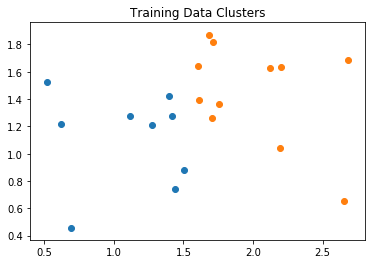

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


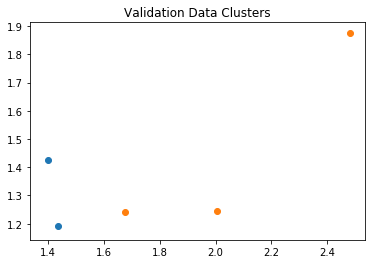

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:18:06] Start training on summe: split 1


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.0.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.0.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.0.pt
Score of this split 0.4676349371077778
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


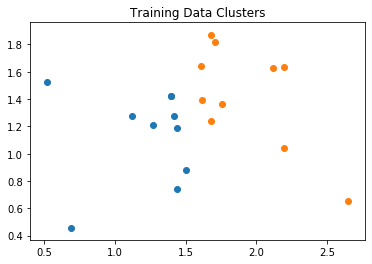

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


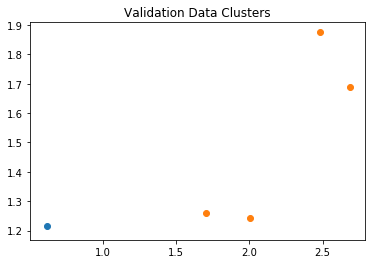

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:18:11] Start training on summe: split 2


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.1.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.1.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.1.pt
Score of this split 0.4719752466232544
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


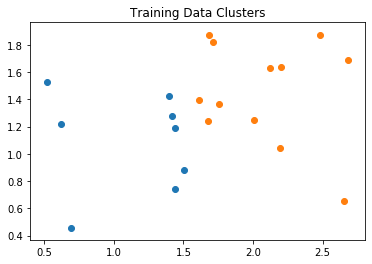

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


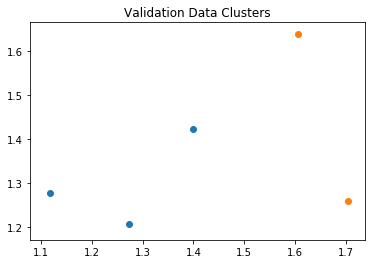

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:18:15] Start training on summe: split 3


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.2.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.2.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.2.pt
Score of this split 0.46305363764517893
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


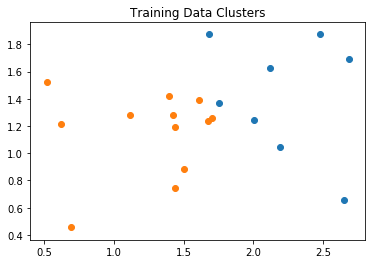

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


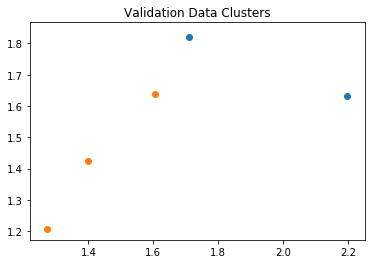

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:18:20] Start training on summe: split 4


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.3.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.3.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.3.pt
Score of this split 0.5156561575996765
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


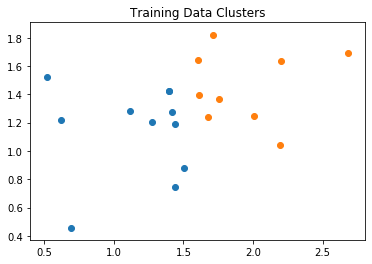

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


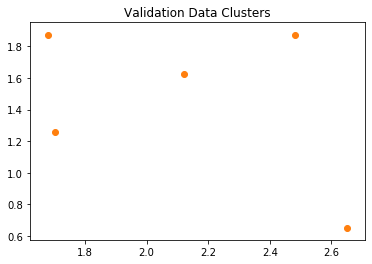

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/05/01 19:18:25] Training done on summe. F-score: 0.4587


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.4.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.4.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.4.pt
Score of this split 0.3754238036417697
[14, 27, 38, 165, 169, 207]
[14, 27, 32, 101, 109, 165, 169, 207]
[14, 27, 32, 101, 109, 165, 169, 207]


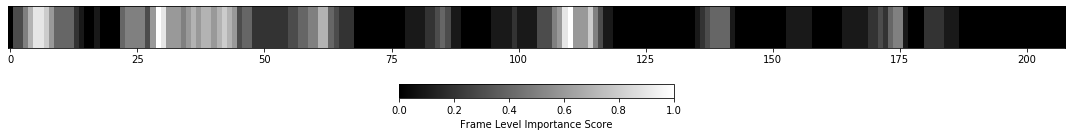

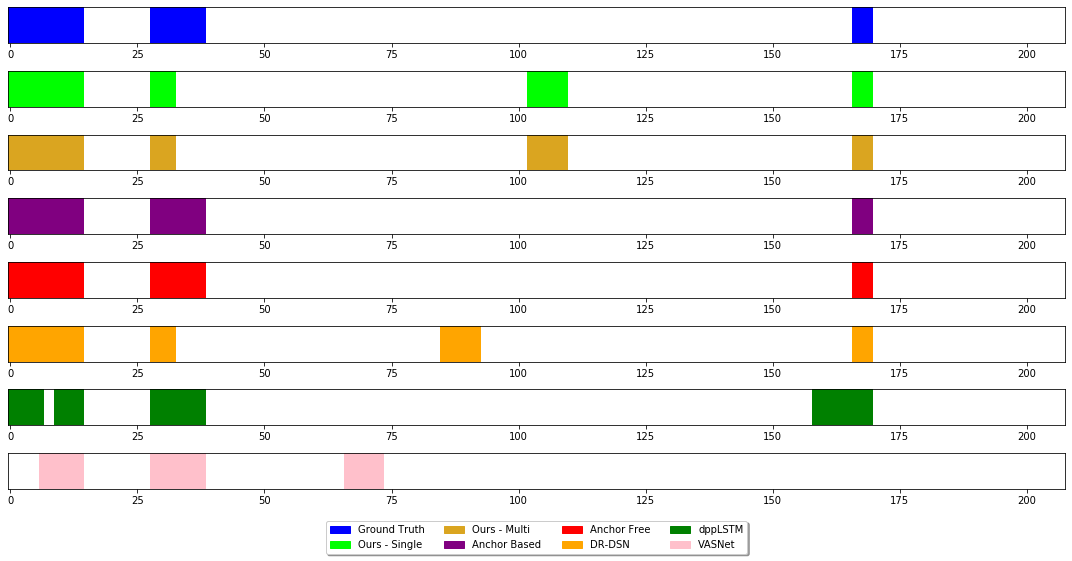

In [10]:
trainAndCompare("../splits/summe.yml",25,manual_results_25,save="./example_visualisations/video_25.png")

### Video 24 of TVSum

[2022/04/28 23:07:35] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 23:07:35] Start training on tvsum: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:07:45] Start training on tvsum: split 1


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.0.pt
Score of this split 0.6208633096874442
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:07:54] Start training on tvsum: split 2


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.1.pt
Score of this split 0.6000947419474623
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:08:04] Start training on tvsum: split 3


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.2.pt
Score of this split 0.6442134381137328
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:08:13] Start training on tvsum: split 4


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.3.pt
Score of this split 0.6288388842959185
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:08:23] Training done on tvsum. F-score: 0.6230
[2022/04/28 23:08:23] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 23:08:23] Start training on tvsum: split 0


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.4.pt
Score of this split 0.6209905808809125
Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


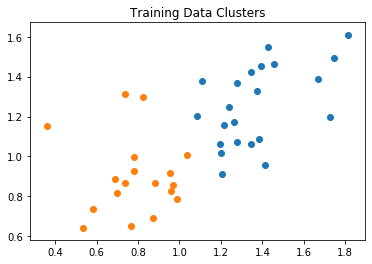

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


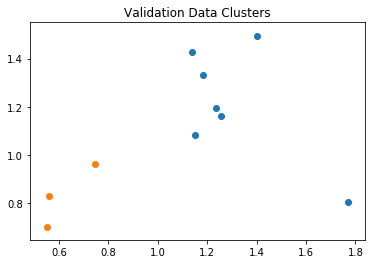

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:08:36] Start training on tvsum: split 1


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.0.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.0.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.0.pt
Score of this split 0.6164538568923541
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


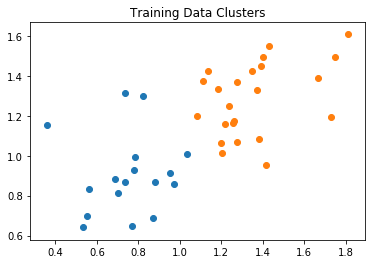

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


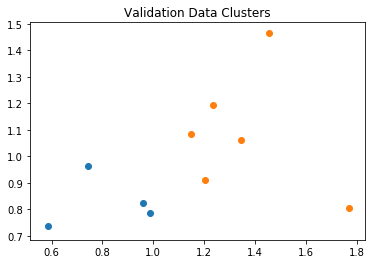

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:08:47] Start training on tvsum: split 2


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.1.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.1.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.1.pt
Score of this split 0.5936910305112194
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


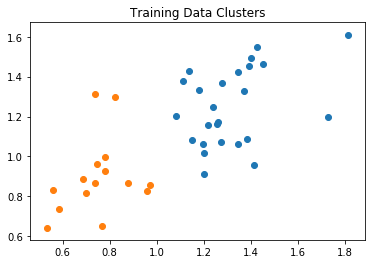

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


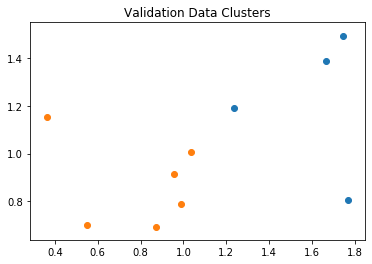

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:09:01] Start training on tvsum: split 3


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.2.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.2.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.2.pt
Score of this split 0.6358936129680084
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


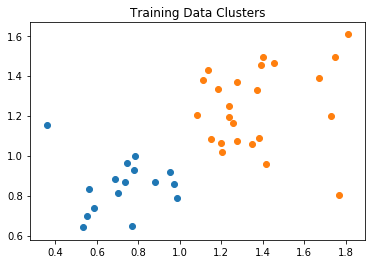

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


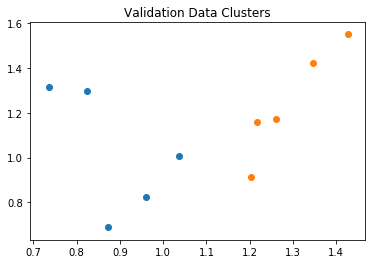

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:09:13] Start training on tvsum: split 4


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.3.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.3.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.3.pt
Score of this split 0.6204512326452807
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


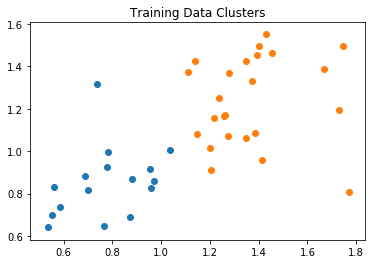

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


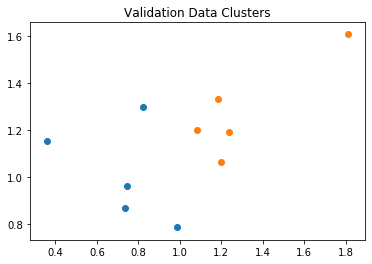

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:09:25] Training done on tvsum. F-score: 0.6183


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.4.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.4.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.4.pt
Score of this split 0.6252593322853652
[11, 17, 39, 45, 113, 122, 148, 159, 182, 188, 198, 203, 290]
[81, 87, 113, 122, 133, 140, 148, 159, 182, 188, 198, 203, 290]
[81, 87, 113, 122, 133, 140, 148, 159, 182, 188, 198, 203, 290]


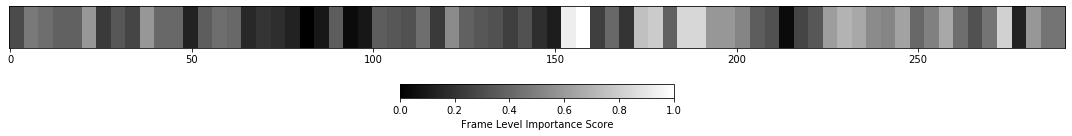

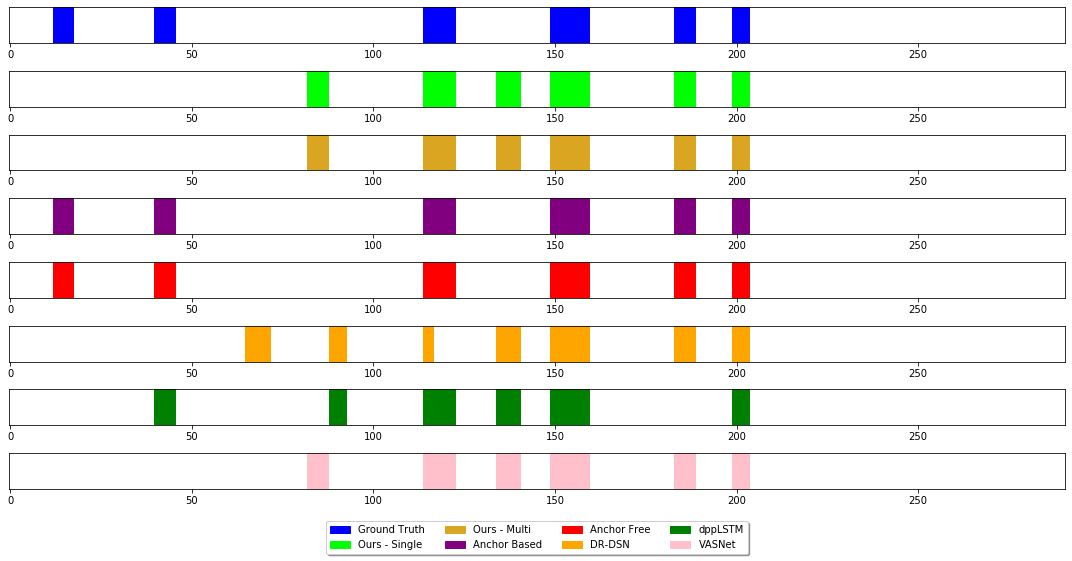

In [10]:
trainAndCompare("../splits/tvsum.yml",24,manual_results_24,save="./example_visualisations/video_24.png")

### Video 42 of TVSum

[2022/04/28 23:09:27] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 23:09:27] Start training on tvsum: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:09:36] Start training on tvsum: split 1


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.0.pt
Score of this split 0.6208633096874442
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:09:48] Start training on tvsum: split 2


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.1.pt
Score of this split 0.6000947419474623
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:09:58] Start training on tvsum: split 3


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.2.pt
Score of this split 0.6442134381137328
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:10:08] Start training on tvsum: split 4


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.3.pt
Score of this split 0.6288388842959185
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:10:18] Training done on tvsum. F-score: 0.6230
[2022/04/28 23:10:18] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 23:10:18] Start training on tvsum: split 0


Model saved to: ../models/ab_basic/checkpoint/tvsum.yml.4.pt
Score of this split 0.6209905808809125
Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


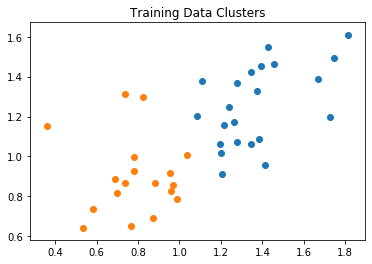

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


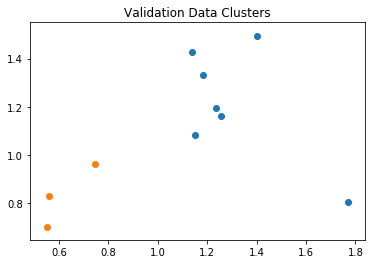

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:10:30] Start training on tvsum: split 1


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.0.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.0.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.0.pt
Score of this split 0.6164538568923541
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


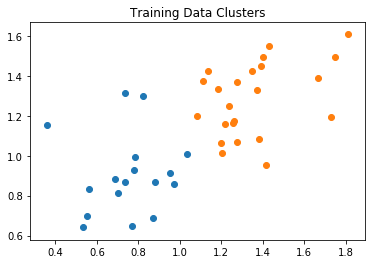

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


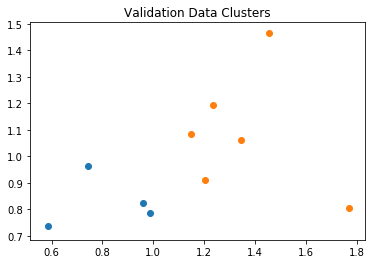

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:10:42] Start training on tvsum: split 2


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.1.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.1.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.1.pt
Score of this split 0.5936910305112194
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


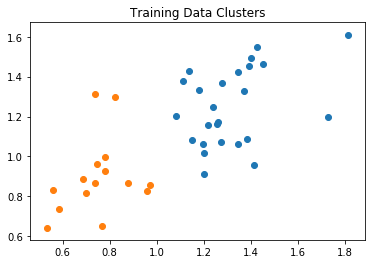

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


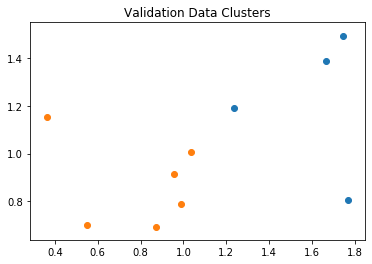

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:10:57] Start training on tvsum: split 3


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.2.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.2.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.2.pt
Score of this split 0.6358936129680084
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


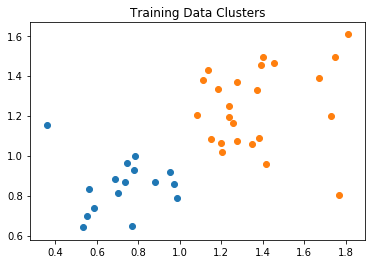

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


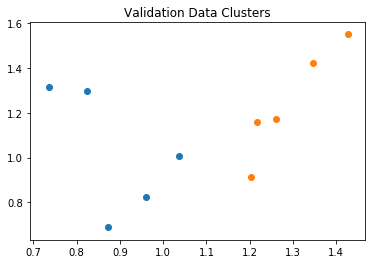

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:11:10] Start training on tvsum: split 4


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.3.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.3.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.3.pt
Score of this split 0.6204512326452807
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


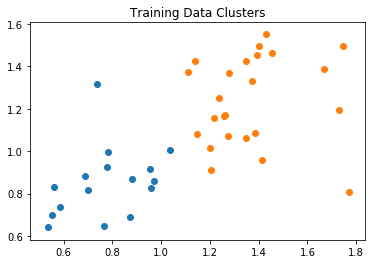

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


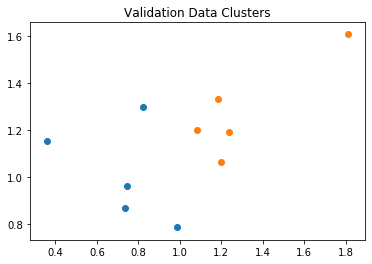

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:11:23] Training done on tvsum. F-score: 0.6183


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_0.4.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_multi_1.4.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_clusterer.4.pt
Score of this split 0.6252593322853652
[3, 33, 42, 69, 75, 90, 96, 194, 202, 264, 268, 282, 289, 334, 350, 395]
[33, 42, 69, 75, 84, 90, 169, 173, 194, 202, 264, 268, 282, 296, 334, 340, 395]
[3, 33, 42, 69, 75, 84, 90, 169, 173, 194, 202, 264, 268, 282, 289, 334, 340, 346, 350, 395]


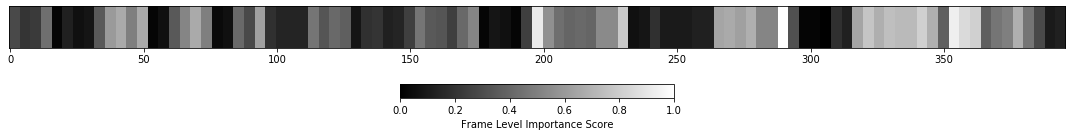

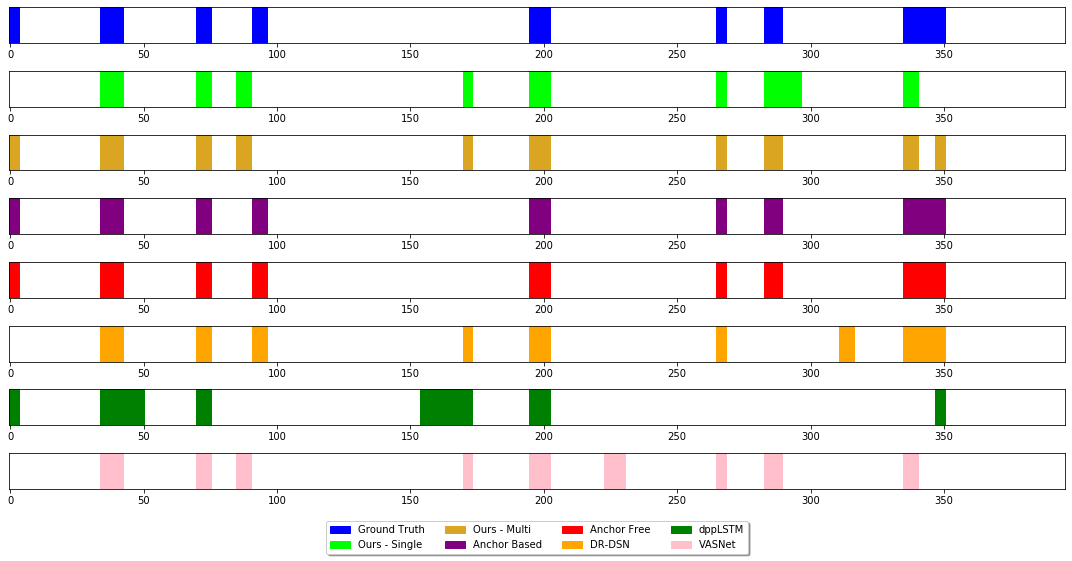

In [11]:
trainAndCompare("../splits/tvsum.yml",42,manual_results_42,save="./example_visualisations/video_42.png")

# Train and Evaluate

These cells contain calls which execute the tests we performed for our results collection in our report. These calls also save the models that are trained. Therefore, running these cells will train a model for the split passed.

To help find the training split you might want to train a model for, the cells are ordered by **dataset**, SumMe or TVSum, **pipeline type**, single or multi, **model base**, RNN or GRU, and **Evaluation Setting**, Conical, Augmented or Transfer.

# SumMe

## Single Model Pipeline

### RNN Base

#### Conical Setting

In [16]:
_ = runTraining("single", passed_splits="../splits/summe.yml", epochs=40)

[2022/04/28 23:22:41] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe.yml'], 'max_epoch': 40, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 23:22:41] Start training on summe: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:22:49] Start training on summe: split 1


Model saved to: ../models/ab_basic/checkpoint/summe.yml.0.pt
Score of this split 0.4719137270433123
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:22:55] Start training on summe: split 2


Model saved to: ../models/ab_basic/checkpoint/summe.yml.1.pt
Score of this split 0.4644979169997375
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:23:01] Start training on summe: split 3


Model saved to: ../models/ab_basic/checkpoint/summe.yml.2.pt
Score of this split 0.43428311517586815
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:23:07] Start training on summe: split 4


Model saved to: ../models/ab_basic/checkpoint/summe.yml.3.pt
Score of this split 0.516138705131969
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:23:17] Training done on summe. F-score: 0.4603


Model saved to: ../models/ab_basic/checkpoint/summe.yml.4.pt
Score of this split 0.4148749941274187


#### Augmented Setting

In [13]:
_ = runTraining("single", passed_splits="../splits/summe_aug.yml", epochs=40)

[2022/04/28 23:11:59] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe_aug.yml'], 'max_epoch': 40, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 23:12:00] Start training on summe_aug: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:12:46] Start training on summe_aug: split 1


Model saved to: ../models/ab_basic/checkpoint/summe_aug.yml.0.pt
Score of this split 0.4599065896274464
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:13:29] Start training on summe_aug: split 2


Model saved to: ../models/ab_basic/checkpoint/summe_aug.yml.1.pt
Score of this split 0.4578157932435004
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:14:12] Start training on summe_aug: split 3


Model saved to: ../models/ab_basic/checkpoint/summe_aug.yml.2.pt
Score of this split 0.48198985481321427
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:14:55] Start training on summe_aug: split 4


Model saved to: ../models/ab_basic/checkpoint/summe_aug.yml.3.pt
Score of this split 0.4857708039589335
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:15:39] Training done on summe_aug. F-score: 0.4496


Model saved to: ../models/ab_basic/checkpoint/summe_aug.yml.4.pt
Score of this split 0.36248674459822666


#### Transfer Setting

In [14]:
_ = runTraining("single", passed_splits="../splits/summe_trans.yml", epochs=40)

[2022/04/28 23:15:39] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe_trans.yml'], 'max_epoch': 40, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 23:15:39] Start training on summe_trans: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:16:22] Start training on summe_trans: split 1


Model saved to: ../models/ab_basic/checkpoint/summe_trans.yml.0.pt
Score of this split 0.43851346261277724
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:17:05] Start training on summe_trans: split 2


Model saved to: ../models/ab_basic/checkpoint/summe_trans.yml.1.pt
Score of this split 0.4389474208335987
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:17:49] Start training on summe_trans: split 3


Model saved to: ../models/ab_basic/checkpoint/summe_trans.yml.2.pt
Score of this split 0.4270947884596741
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:18:31] Start training on summe_trans: split 4


Model saved to: ../models/ab_basic/checkpoint/summe_trans.yml.3.pt
Score of this split 0.4284214700095987
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:19:16] Training done on summe_trans. F-score: 0.4332


Model saved to: ../models/ab_basic/checkpoint/summe_trans.yml.4.pt
Score of this split 0.4330763890777821


### GRU Base

#### Conical Setting

In [9]:
_ = runTraining("single", passed_splits="../splits/summe.yml", epochs=40, base="GRU")

[2022/05/01 19:12:49] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/05/01 19:12:49] Start training on summe: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/05/01 19:13:08] Start training on summe: split 1


Model saved to: ../models/ab_basic/checkpoint/summe.yml.0.pt
Score of this split 0.4436165324370915
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/05/01 19:13:25] Start training on summe: split 2


Model saved to: ../models/ab_basic/checkpoint/summe.yml.1.pt
Score of this split 0.45842047910025413
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/05/01 19:13:42] Start training on summe: split 3


Model saved to: ../models/ab_basic/checkpoint/summe.yml.2.pt
Score of this split 0.43429040666366137
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/05/01 19:14:00] Start training on summe: split 4


Model saved to: ../models/ab_basic/checkpoint/summe.yml.3.pt
Score of this split 0.4333485798750469
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/05/01 19:14:17] Training done on summe. F-score: 0.4318


Model saved to: ../models/ab_basic/checkpoint/summe.yml.4.pt
Score of this split 0.3895587763878337


#### Augmented Setting

[2022/04/23 21:26:12] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe_aug.yml'], 'max_epoch': 40, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 21:26:12] Start training on summe_aug: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


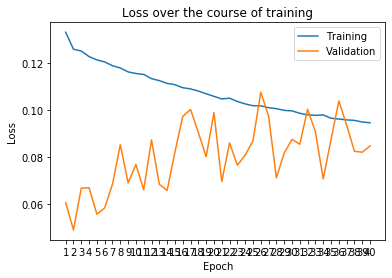

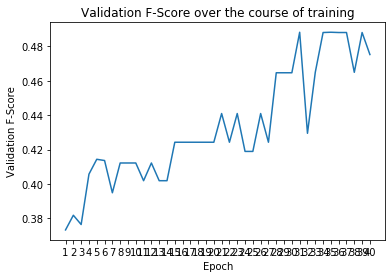

[2022/04/23 21:30:58] Start training on summe_aug: split 1


Score of this split 0.4881964399437401
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


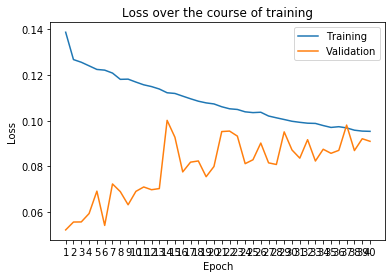

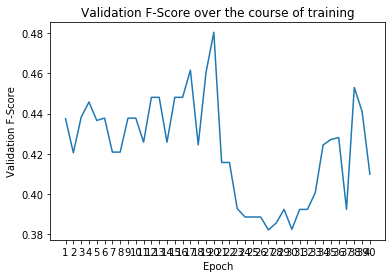

[2022/04/23 21:35:44] Start training on summe_aug: split 2


Score of this split 0.4805122140966359
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


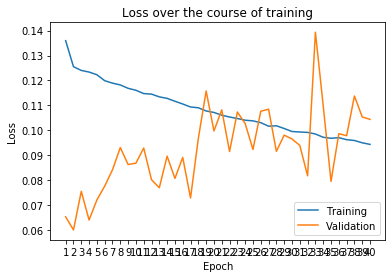

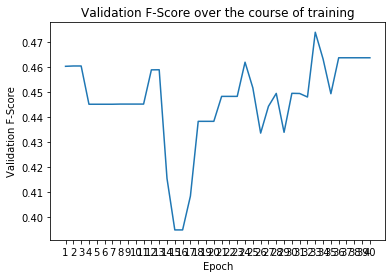

[2022/04/23 21:40:30] Start training on summe_aug: split 3


Score of this split 0.47377562916959504
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


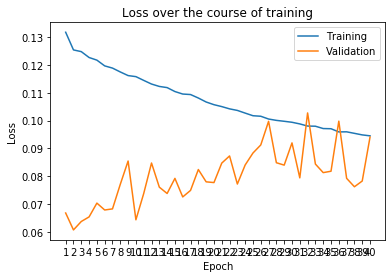

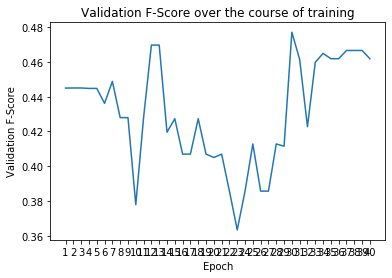

[2022/04/23 21:45:17] Start training on summe_aug: split 4


Score of this split 0.47704419354205385
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


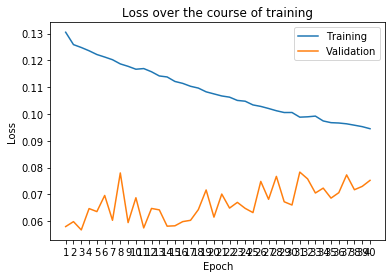

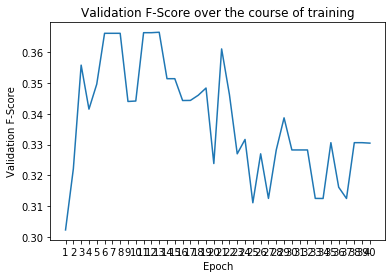

[2022/04/23 21:50:02] Training done on summe_aug. F-score: 0.4572


Score of this split 0.366485670623506


In [21]:
_ = runTraining("single", passed_splits="../splits/summe_aug.yml", epochs=40, base="GRU",plot=True)

#### Transfer Setting

In [22]:
_ = runTraining("single", passed_splits="../splits/summe_trans.yml", epochs=40, base="GRU")

[2022/04/23 21:50:02] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe_trans.yml'], 'max_epoch': 40, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 21:50:02] Start training on summe_trans: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 21:54:28] Start training on summe_trans: split 1


Score of this split 0.4561852270845155
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 21:58:54] Start training on summe_trans: split 2


Score of this split 0.4290325549708719
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:03:19] Start training on summe_trans: split 3


Score of this split 0.43152969342650593
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:07:45] Start training on summe_trans: split 4


Score of this split 0.44135055515407345
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:12:10] Training done on summe_trans. F-score: 0.4393


Score of this split 0.4382994487690206


## Multi Model Pipeline

### RNN Base

#### Conical Setting

[2022/04/28 23:23:17] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe.yml'], 'max_epoch': 40, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 23:23:17] Start training on summe: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


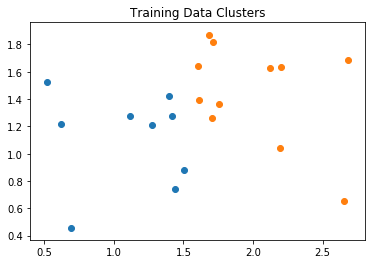

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


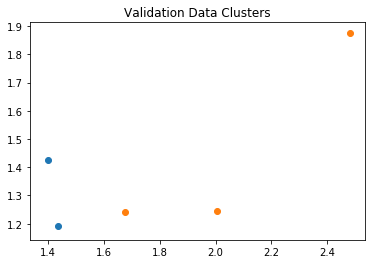

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:23:25] Start training on summe: split 1


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.0.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.0.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.0.pt
Score of this split 0.4707686707526249
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


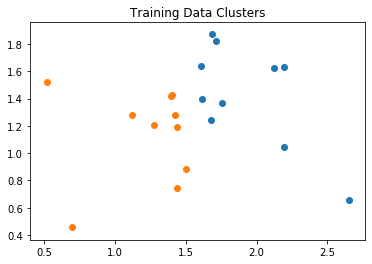

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


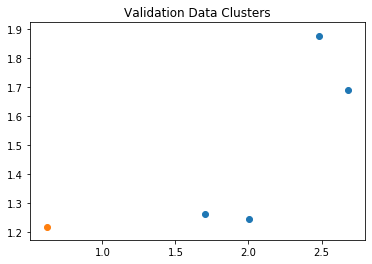

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:23:33] Start training on summe: split 2


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.1.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.1.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.1.pt
Score of this split 0.4586855413376741
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


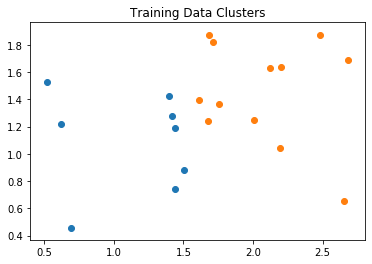

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


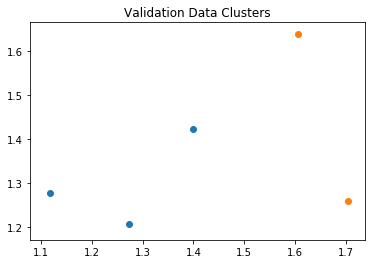

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:23:41] Start training on summe: split 3


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.2.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.2.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.2.pt
Score of this split 0.46305363764517893
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


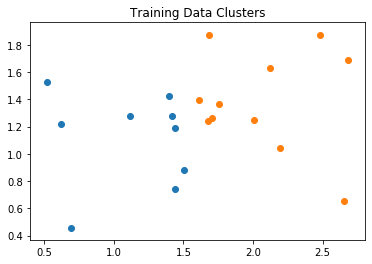

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


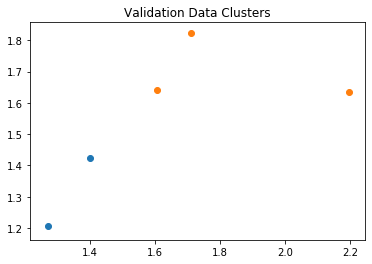

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:23:50] Start training on summe: split 4


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.3.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.3.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.3.pt
Score of this split 0.5007140020130825
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


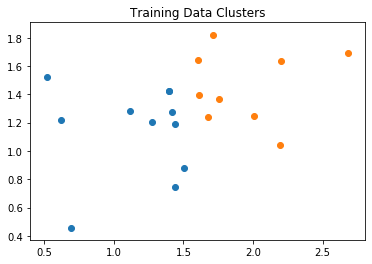

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


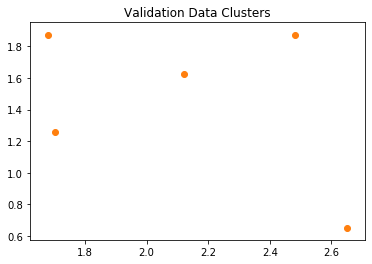

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 23:23:58] Training done on summe. F-score: 0.4571


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_0.4.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_multi_1.4.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_clusterer.4.pt
Score of this split 0.39236950452584957


In [17]:
_ = runTraining("multi", passed_splits="../splits/summe.yml", epochs=40)

#### Augmented Setting

[2022/04/28 14:37:20] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe_aug.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 14:37:20] Start training on summe_aug: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


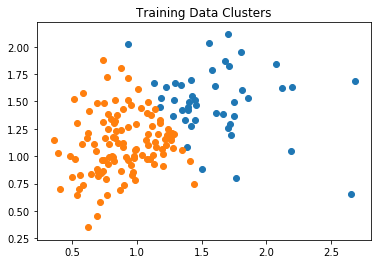

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


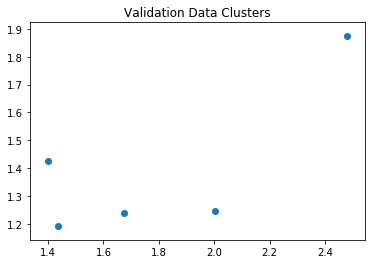

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:38:10] Start training on summe_aug: split 1


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_0.0.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_1.0.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_aug_clusterer.0.pt
Score of this split 0.46031451638808785
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


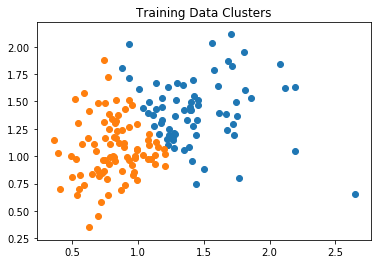

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


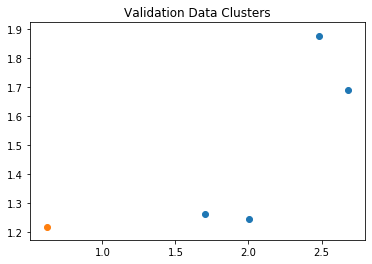

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:38:59] Start training on summe_aug: split 2


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_0.1.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_1.1.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_aug_clusterer.1.pt
Score of this split 0.4728769788328383
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


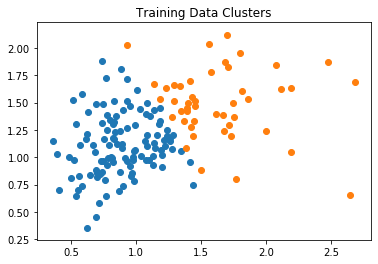

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


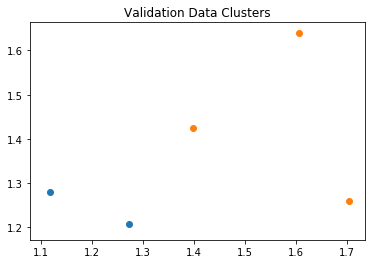

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:39:48] Start training on summe_aug: split 3


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_0.2.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_1.2.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_aug_clusterer.2.pt
Score of this split 0.5373080554323235
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


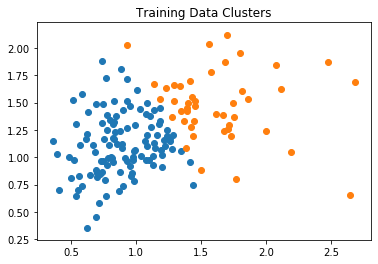

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


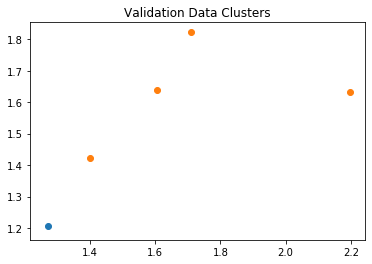

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:40:37] Start training on summe_aug: split 4


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_0.3.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_1.3.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_aug_clusterer.3.pt
Score of this split 0.48107072481604857
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


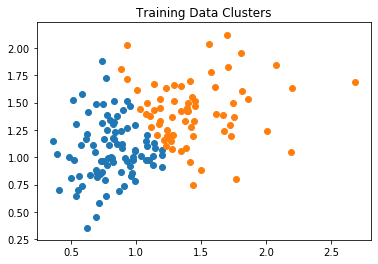

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


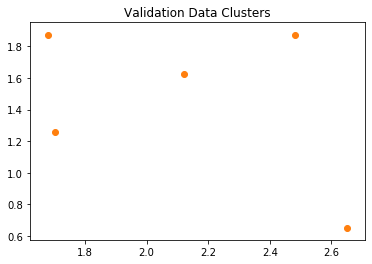

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:41:28] Training done on summe_aug. F-score: 0.4724


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_0.4.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_aug_multi_1.4.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_aug_clusterer.4.pt
Score of this split 0.410454271885103


In [16]:
_ = runTraining("multi",passed_splits="../splits/summe_aug.yml")

#### Transfer Setting

[2022/04/28 14:41:28] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe_trans.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 14:41:28] Start training on summe_trans: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


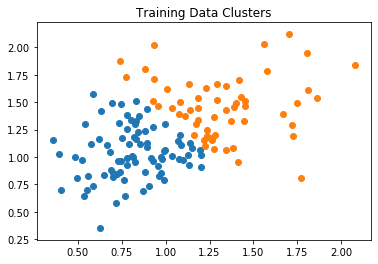

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


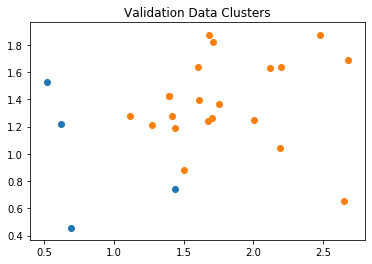

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:42:17] Start training on summe_trans: split 1


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_0.0.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_1.0.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_trans_clusterer.0.pt
Score of this split 0.4469509963406715
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


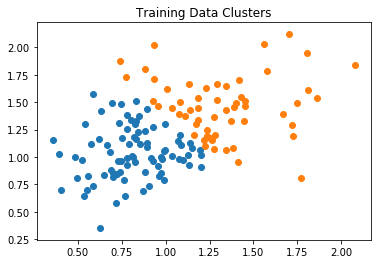

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


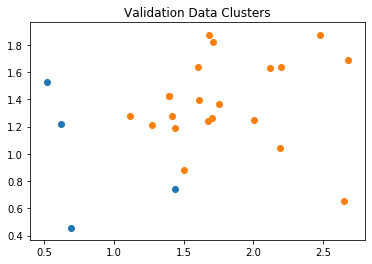

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:43:06] Start training on summe_trans: split 2


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_0.1.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_1.1.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_trans_clusterer.1.pt
Score of this split 0.43639783825718176
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


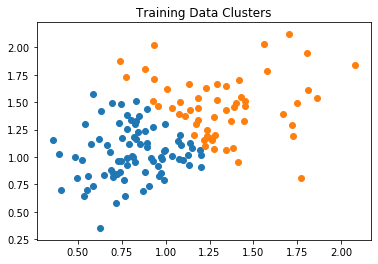

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


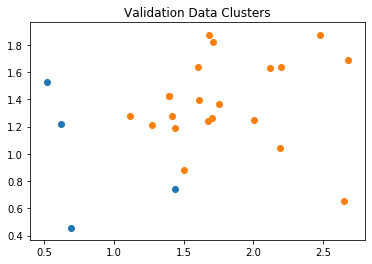

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:43:55] Start training on summe_trans: split 3


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_0.2.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_1.2.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_trans_clusterer.2.pt
Score of this split 0.43771786690061876
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


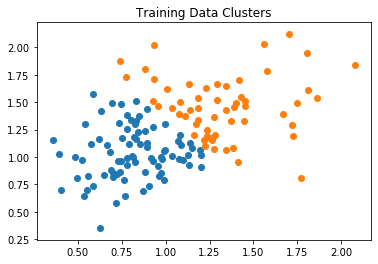

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


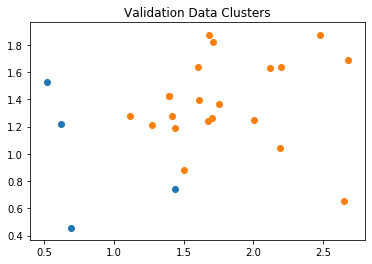

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:44:45] Start training on summe_trans: split 4


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_0.3.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_1.3.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_trans_clusterer.3.pt
Score of this split 0.4321170580275474
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


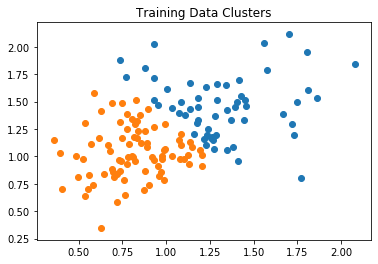

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


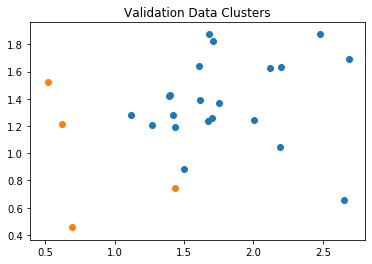

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:45:34] Training done on summe_trans. F-score: 0.4360


[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_0.4.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/summe_trans_multi_1.4.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/summe_trans_clusterer.4.pt
Score of this split 0.4267339531150107


In [17]:
_ = runTraining("multi",passed_splits="../splits/summe_trans.yml")

### GRU Base

#### Conical Setting

[2022/04/23 22:17:47] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe.yml'], 'max_epoch': 40, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 22:17:47] Start training on summe: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


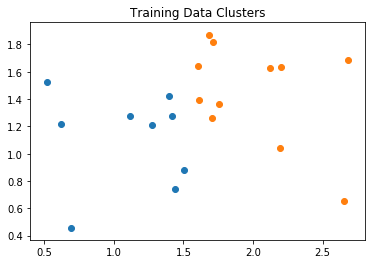

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


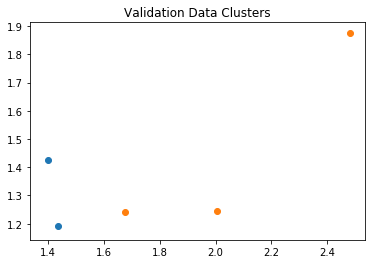

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:18:22] Start training on summe: split 1


Score of this split 0.4420704392202107
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


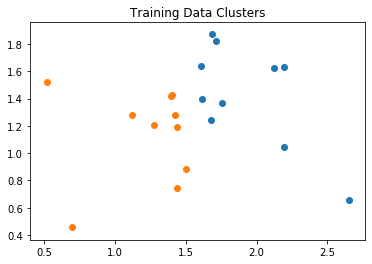

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


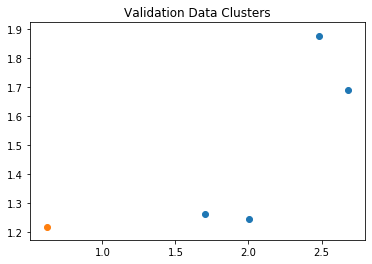

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:18:57] Start training on summe: split 2


Score of this split 0.4761522762644336
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


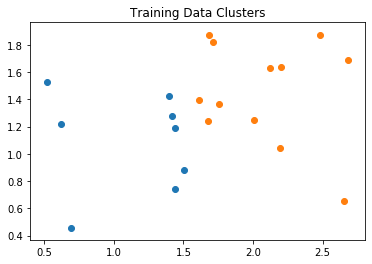

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


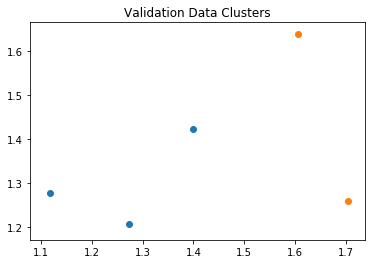

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:19:33] Start training on summe: split 3


Score of this split 0.49246657762879914
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


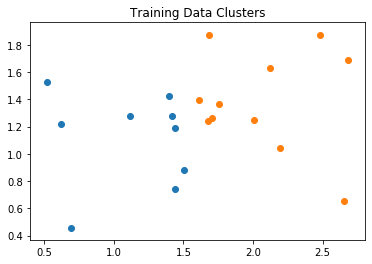

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


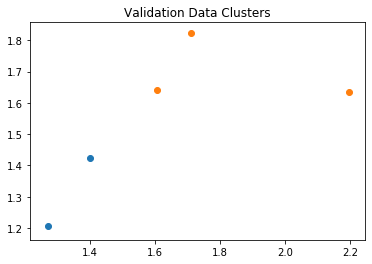

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:20:09] Start training on summe: split 4


Score of this split 0.45764428813984565
Number of Training Features to cluster for this split: 20
Feature Shape: (2,)
Number of Training Keys: 20
Number of clusters: 2


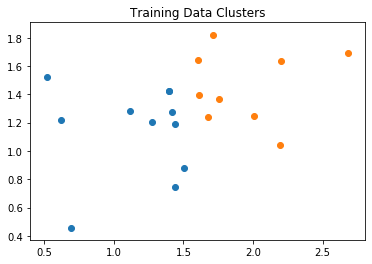

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


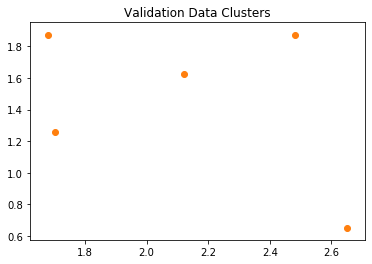

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:20:44] Training done on summe. F-score: 0.4552


Score of this split 0.4076533780971622


In [26]:
_ = runTraining("multi", passed_splits="../splits/summe.yml", epochs=40, base="GRU")

#### Augmented Setting

[2022/04/23 22:20:44] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe_aug.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 22:20:44] Start training on summe_aug: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


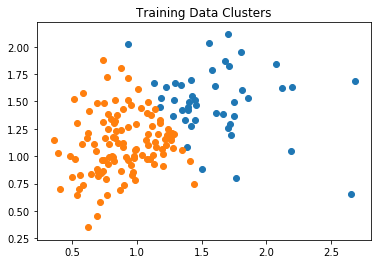

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


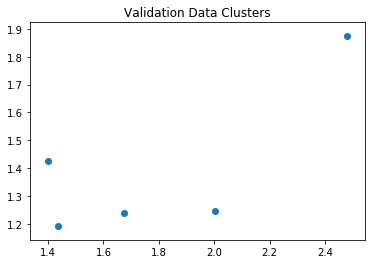

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:23:16] Start training on summe_aug: split 1


Score of this split 0.43391938868942354
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


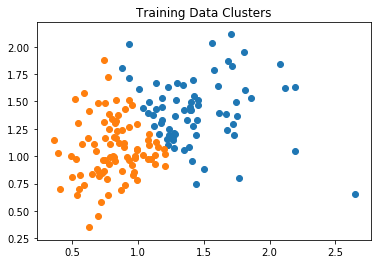

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


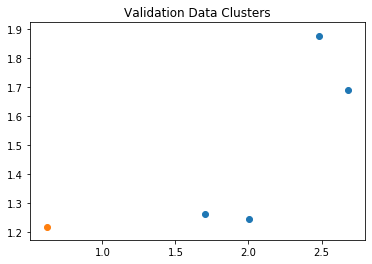

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:25:48] Start training on summe_aug: split 2


Score of this split 0.4461043920297266
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


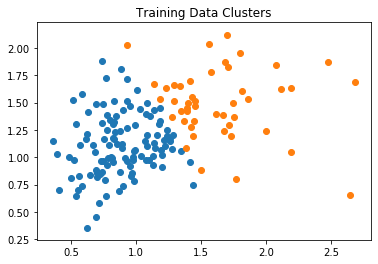

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


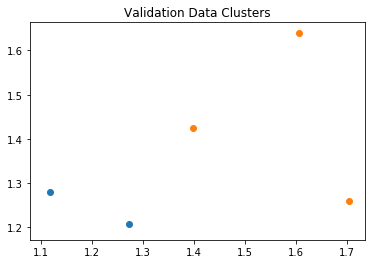

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:28:21] Start training on summe_aug: split 3


Score of this split 0.46457928007644983
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


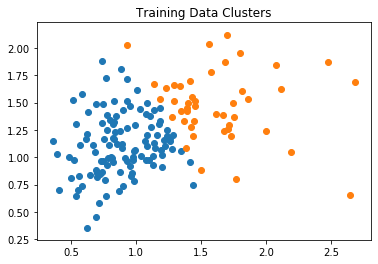

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


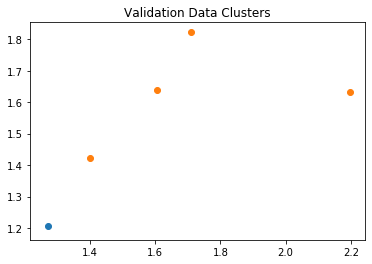

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:30:54] Start training on summe_aug: split 4


Score of this split 0.4897411486786953
Number of Training Features to cluster for this split: 159
Feature Shape: (2,)
Number of Training Keys: 159
Number of clusters: 2


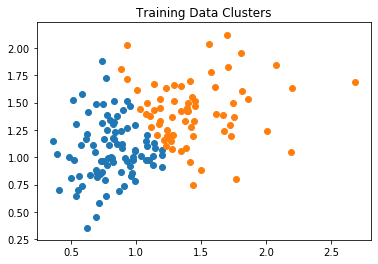

Number of Validation Features to cluster for this split: 5
Number of Validation Keys: 5


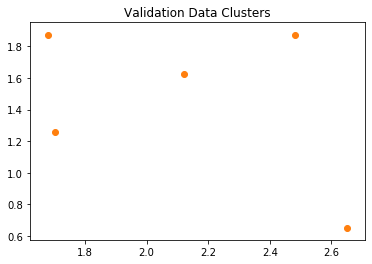

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:33:26] Training done on summe_aug. F-score: 0.4431


Score of this split 0.3810863872317878


In [27]:
_ = runTraining("multi",passed_splits="../splits/summe_aug.yml", base="GRU")

#### Transfer Setting

[2022/04/23 22:33:26] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/summe_trans.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 22:33:26] Start training on summe_trans: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


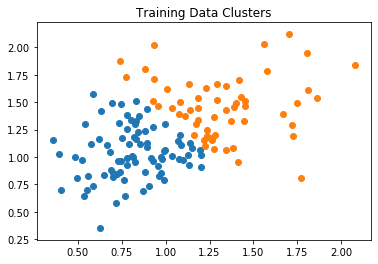

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


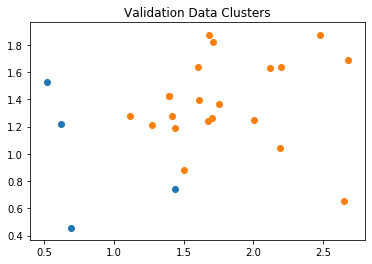

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:35:48] Start training on summe_trans: split 1


Score of this split 0.4375718811331729
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


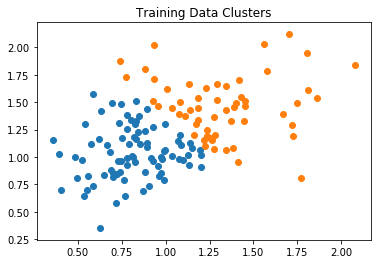

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


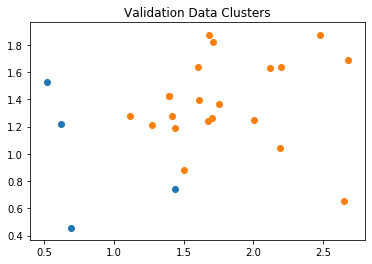

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:38:10] Start training on summe_trans: split 2


Score of this split 0.4294962667501128
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


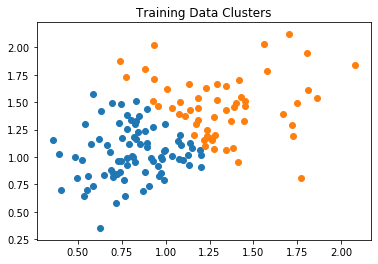

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


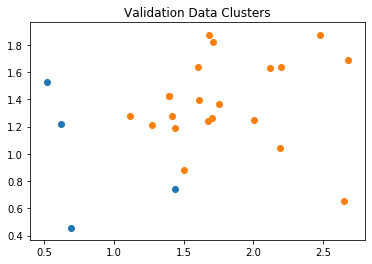

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:40:33] Start training on summe_trans: split 3


Score of this split 0.45217648113490094
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


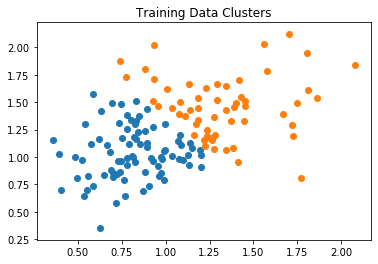

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


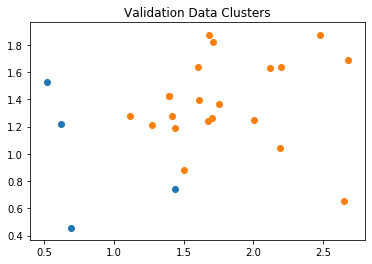

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:42:55] Start training on summe_trans: split 4


Score of this split 0.4408689604469926
Number of Training Features to cluster for this split: 139
Feature Shape: (2,)
Number of Training Keys: 139
Number of clusters: 2


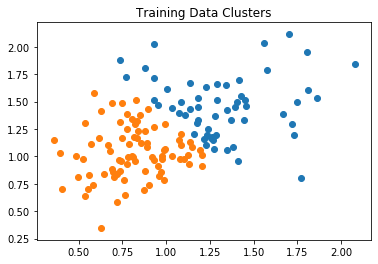

Number of Validation Features to cluster for this split: 25
Number of Validation Keys: 25


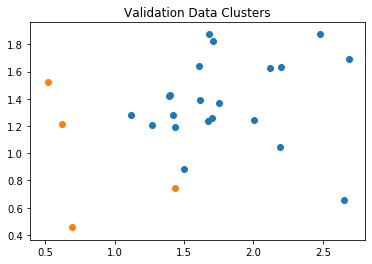

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:45:18] Training done on summe_trans. F-score: 0.4351


Score of this split 0.41528468618110975


In [28]:
_ = runTraining("multi",passed_splits="../splits/summe_trans.yml", base="GRU")

# TVSum

## Single Model Pipeline

### RNN Base

#### Conical Setting

In [29]:
_ = runTraining("single",passed_splits="../splits/tvsum.yml")

[2022/04/23 22:45:18] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 22:45:18] Start training on tvsum: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:45:27] Start training on tvsum: split 1


Score of this split 0.6208633096874442
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:45:35] Start training on tvsum: split 2


Score of this split 0.6000947419474623
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:45:43] Start training on tvsum: split 3


Score of this split 0.6442134381137328
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:45:52] Start training on tvsum: split 4


Score of this split 0.6288388842959185
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:46:00] Training done on tvsum. F-score: 0.6230


Score of this split 0.6209905808809125


#### Augmented Setting

In [30]:
_ = runTraining("single",passed_splits="../splits/tvsum_aug.yml")

[2022/04/23 22:46:00] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum_aug.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 22:46:00] Start training on tvsum_aug: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:46:24] Start training on tvsum_aug: split 1


Score of this split 0.6022047124306352
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:46:47] Start training on tvsum_aug: split 2


Score of this split 0.5918470742306079
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:47:10] Start training on tvsum_aug: split 3


Score of this split 0.6322471790323473
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:47:34] Start training on tvsum_aug: split 4


Score of this split 0.6274451541643862
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:47:57] Training done on tvsum_aug. F-score: 0.6136


Score of this split 0.6144255216259558


#### Transfer Setting

In [31]:
_ = runTraining("single",passed_splits="../splits/tvsum_trans.yml")

[2022/04/23 22:47:57] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum_trans.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 22:47:57] Start training on tvsum_trans: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:48:22] Start training on tvsum_trans: split 1


Score of this split 0.5717248175750506
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:48:47] Start training on tvsum_trans: split 2


Score of this split 0.5699868218782314
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:49:13] Start training on tvsum_trans: split 3


Score of this split 0.571205088928299
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:49:38] Start training on tvsum_trans: split 4


Score of this split 0.5713746192786662
Models being used: {-1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 22:50:03] Training done on tvsum_trans. F-score: 0.5706


Score of this split 0.5687481726859953


### GRU Base

#### Conical Setting

In [32]:
_ = runTraining("single",passed_splits="../splits/tvsum.yml", base="GRU")

[2022/04/23 22:50:03] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 22:50:03] Start training on tvsum: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:50:58] Start training on tvsum: split 1


Score of this split 0.621044323301063
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:51:53] Start training on tvsum: split 2


Score of this split 0.5883099410412742
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:52:47] Start training on tvsum: split 3


Score of this split 0.6366697716068764
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:53:40] Start training on tvsum: split 4


Score of this split 0.6161226512665317
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:54:35] Training done on tvsum. F-score: 0.6201


Score of this split 0.6381303556314307


#### Augmented Setting

In [33]:
_ = runTraining("single",passed_splits="../splits/tvsum_aug.yml", base="GRU")

[2022/04/23 22:54:35] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum_aug.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 22:54:35] Start training on tvsum_aug: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:56:55] Start training on tvsum_aug: split 1


Score of this split 0.6245793177659561
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 22:59:15] Start training on tvsum_aug: split 2


Score of this split 0.5873446788055061
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:01:35] Start training on tvsum_aug: split 3


Score of this split 0.6427472088270758
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:03:54] Start training on tvsum_aug: split 4


Score of this split 0.6160589814681
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:06:14] Training done on tvsum_aug. F-score: 0.6184


Score of this split 0.6210656596572195


#### Transfer Setting

In [34]:
_ = runTraining("single",passed_splits="../splits/tvsum_trans.yml", base="GRU")

[2022/04/23 23:06:14] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum_trans.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 23:06:14] Start training on tvsum_trans: split 0


Running in mode: single
Running in Feature Mode: precomputed
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:08:04] Start training on tvsum_trans: split 1


Score of this split 0.5733464102347948
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:09:53] Start training on tvsum_trans: split 2


Score of this split 0.5793462471364241
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:11:43] Start training on tvsum_trans: split 3


Score of this split 0.581925526166938
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:13:33] Start training on tvsum_trans: split 4


Score of this split 0.5753814697351152
Models being used: {-1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:15:22] Training done on tvsum_trans. F-score: 0.5754


Score of this split 0.567002835951929


## Multi Model Pipeline

### RNN Base

#### Conical Setting

[2022/04/23 23:15:22] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 23:15:23] Start training on tvsum: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


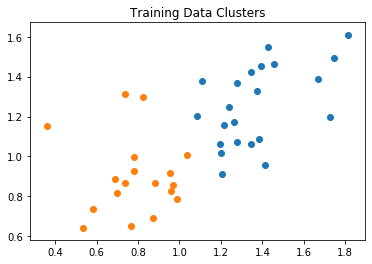

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


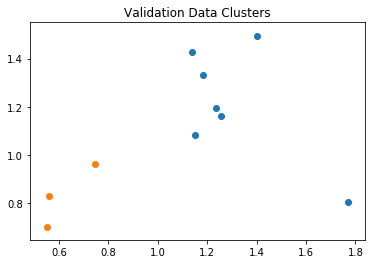

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 23:15:34] Start training on tvsum: split 1


Score of this split 0.6164538568923541
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


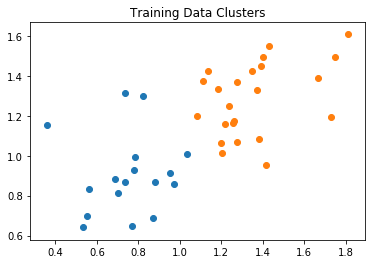

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


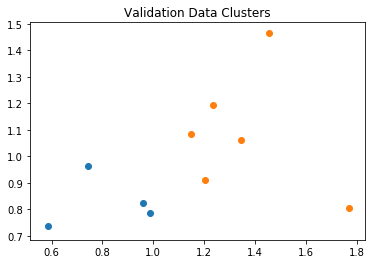

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 23:15:45] Start training on tvsum: split 2


Score of this split 0.5936910305112194
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


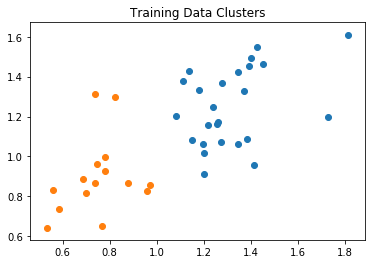

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


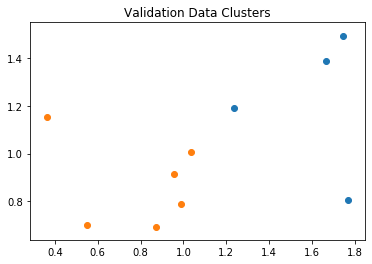

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 23:15:56] Start training on tvsum: split 3


Score of this split 0.6358936129680084
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


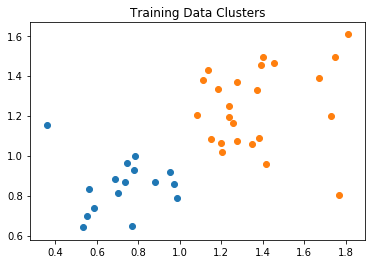

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


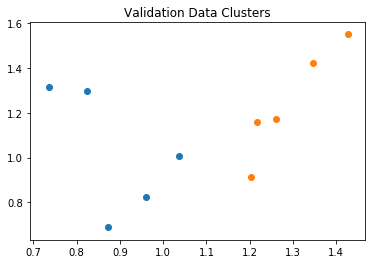

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 23:16:07] Start training on tvsum: split 4


Score of this split 0.6204512326452807
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


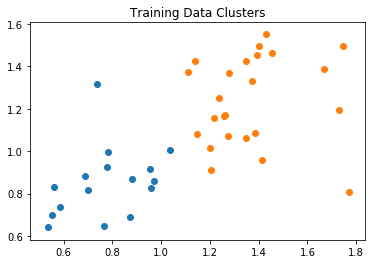

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


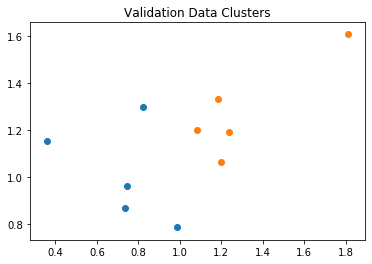

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/23 23:16:18] Training done on tvsum. F-score: 0.6183


Score of this split 0.6252593322853652


In [35]:
_ = runTraining("multi",passed_splits="../splits/tvsum.yml")

#### Augmented Setting

[2022/04/28 14:45:34] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum_aug.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 14:45:34] Start training on tvsum_aug: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


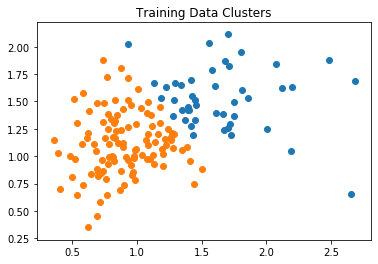

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


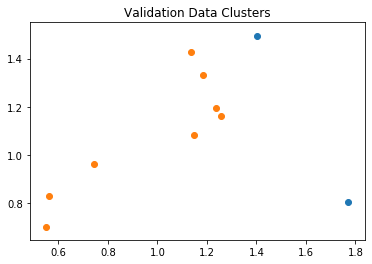

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:46:25] Start training on tvsum_aug: split 1


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_0.0.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_1.0.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_aug_clusterer.0.pt
Score of this split 0.621801966160492
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


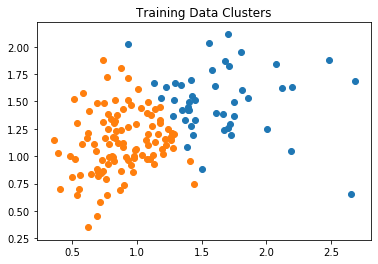

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


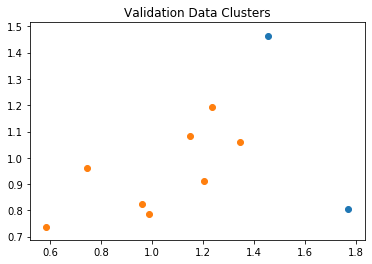

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:47:16] Start training on tvsum_aug: split 2


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_0.1.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_1.1.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_aug_clusterer.1.pt
Score of this split 0.5966412816552829
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


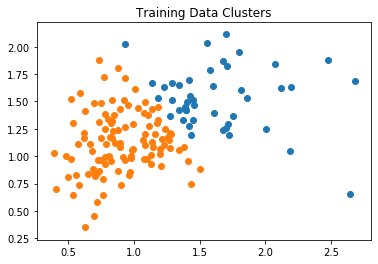

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


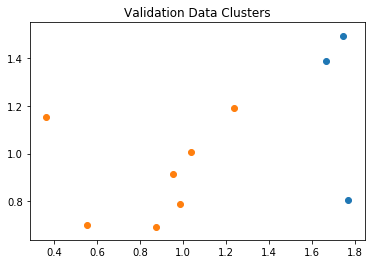

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:48:05] Start training on tvsum_aug: split 3


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_0.2.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_1.2.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_aug_clusterer.2.pt
Score of this split 0.6341243461722599
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


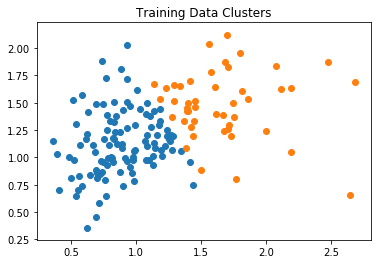

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


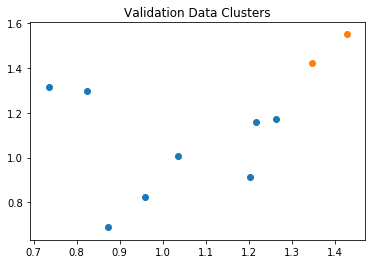

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:48:56] Start training on tvsum_aug: split 4


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_0.3.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_1.3.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_aug_clusterer.3.pt
Score of this split 0.6212193066460003
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


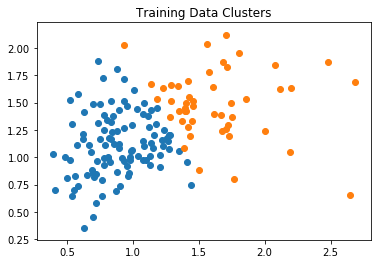

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


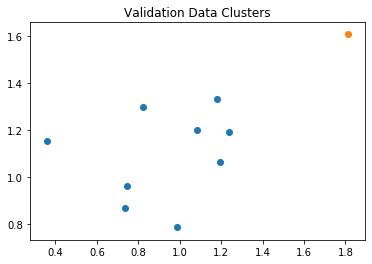

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:49:47] Training done on tvsum_aug. F-score: 0.6197


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_0.4.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_aug_multi_1.4.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_aug_clusterer.4.pt
Score of this split 0.6247950771000492


In [18]:
_ = runTraining("multi",passed_splits="../splits/tvsum_aug.yml")

#### Transfer Setting

[2022/04/28 14:49:47] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum_trans.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024', 'pipeline_mode': 'single'}
[2022/04/28 14:49:47] Start training on tvsum_trans: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


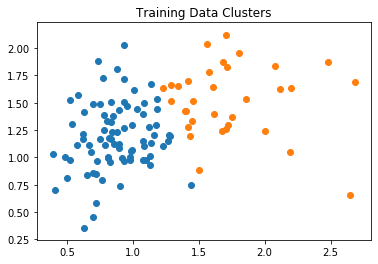

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


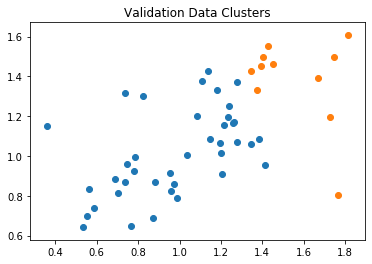

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:50:42] Start training on tvsum_trans: split 1


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_0.0.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_1.0.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_trans_clusterer.0.pt
Score of this split 0.5747686393111578
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


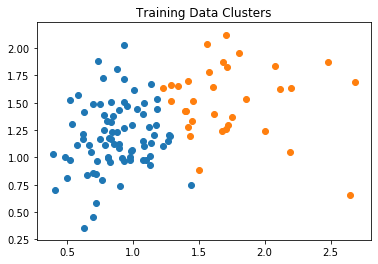

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


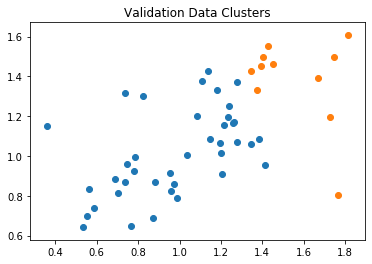

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:51:35] Start training on tvsum_trans: split 2


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_0.1.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_1.1.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_trans_clusterer.1.pt
Score of this split 0.5709799147377931
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


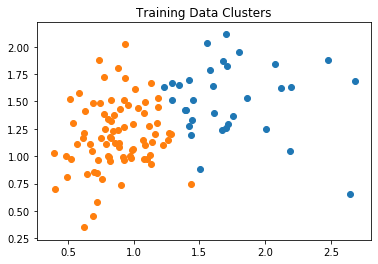

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


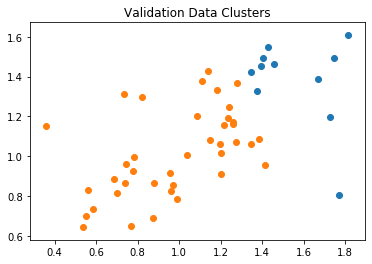

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:52:28] Start training on tvsum_trans: split 3


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_0.2.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_1.2.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_trans_clusterer.2.pt
Score of this split 0.5741691135371302
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


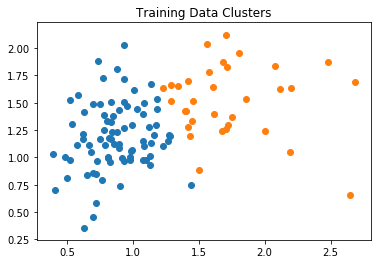

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


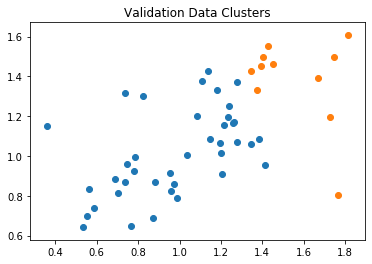

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:53:20] Start training on tvsum_trans: split 4


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_0.3.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_1.3.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_trans_clusterer.3.pt
Score of this split 0.574471980151302
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


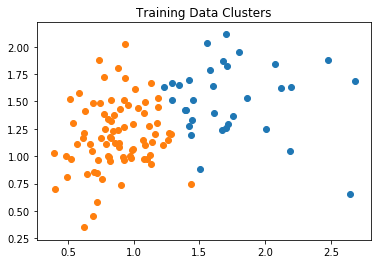

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


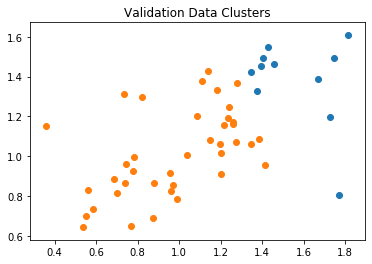

Models being used: {0: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
), 1: BasicRNN(
  (rnn): RNN(1024, 128, num_layers=3)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)}


[2022/04/28 14:54:14] Training done on tvsum_trans. F-score: 0.5740


[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_0.4.pt
[Multi] Model saved to: ../models/ab_basic/checkpoint/tvsum_trans_multi_1.4.pt
[Multi] Clusterer saved to: ../models/ab_basic/checkpoint/tvsum_trans_clusterer.4.pt
Score of this split 0.5753789810831502


In [19]:
_ = runTraining("multi",passed_splits="../splits/tvsum_trans.yml")

### GRU Base

#### Conical Setting

[2022/04/23 23:21:35] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 23:21:35] Start training on tvsum: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


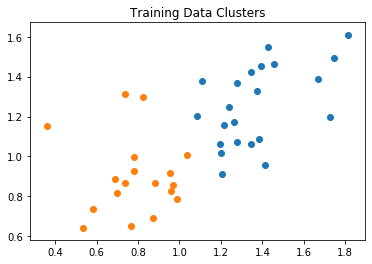

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


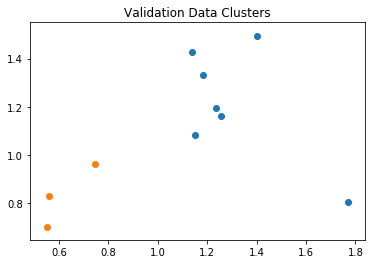

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:22:31] Start training on tvsum: split 1


Score of this split 0.6242511729016619
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


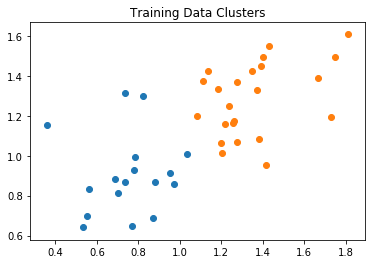

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


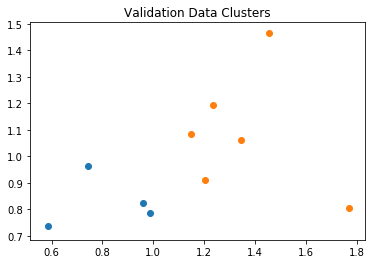

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:23:29] Start training on tvsum: split 2


Score of this split 0.5851190988833789
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


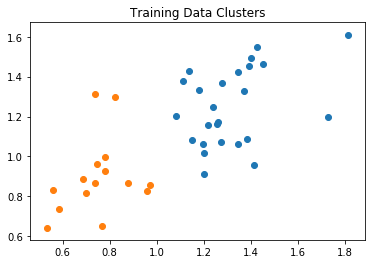

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


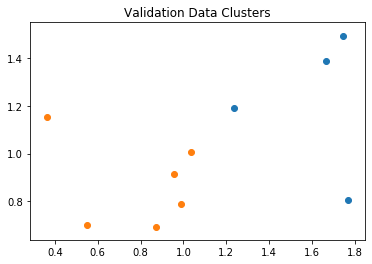

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:24:26] Start training on tvsum: split 3


Score of this split 0.6372674535311142
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


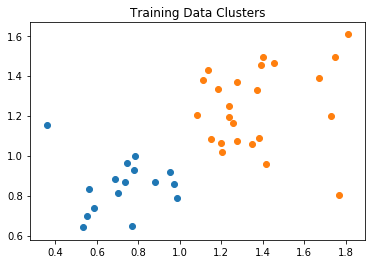

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


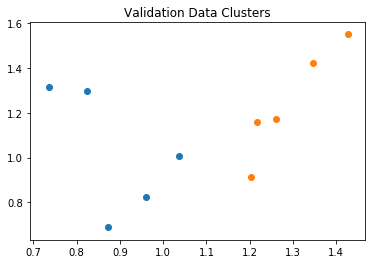

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:25:21] Start training on tvsum: split 4


Score of this split 0.6121168086122979
Number of Training Features to cluster for this split: 40
Feature Shape: (2,)
Number of Training Keys: 40
Number of clusters: 2


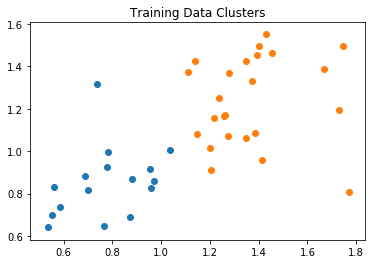

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


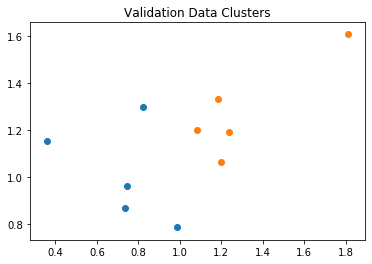

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:26:19] Training done on tvsum. F-score: 0.6168


Score of this split 0.6251529612452876


In [38]:
_ = runTraining("multi",passed_splits="../splits/tvsum.yml", base="GRU")

#### Augmented Setting

[2022/04/23 23:26:19] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum_aug.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 23:26:19] Start training on tvsum_aug: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


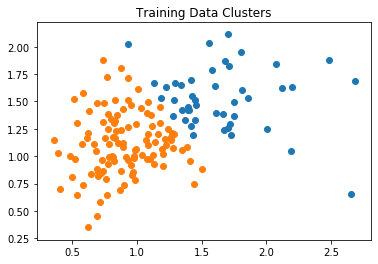

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


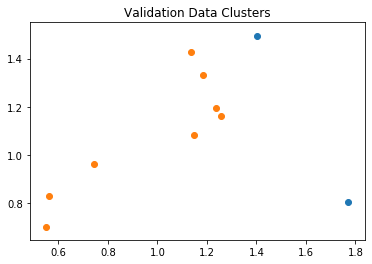

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:28:45] Start training on tvsum_aug: split 1


Score of this split 0.6209209190352446
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


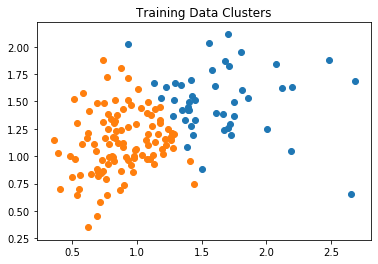

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


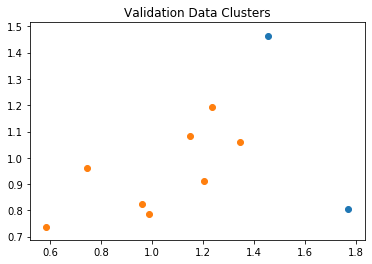

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:31:13] Start training on tvsum_aug: split 2


Score of this split 0.574440789755179
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


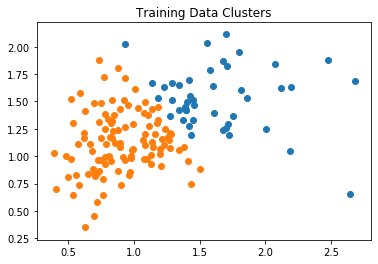

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


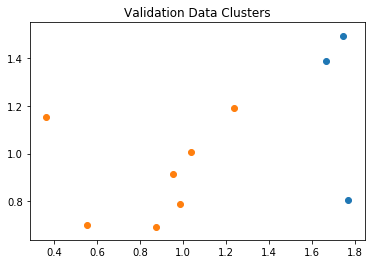

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:33:40] Start training on tvsum_aug: split 3


Score of this split 0.6362760732292678
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


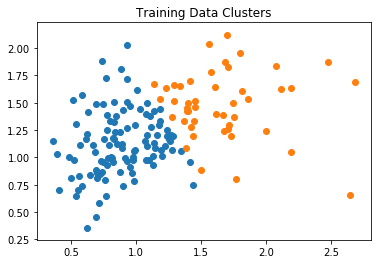

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


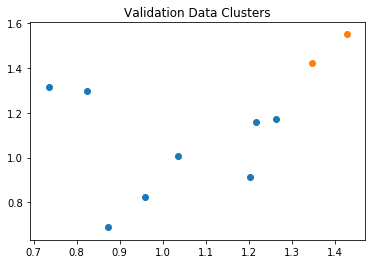

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:36:06] Start training on tvsum_aug: split 4


Score of this split 0.6023266127905037
Number of Training Features to cluster for this split: 154
Feature Shape: (2,)
Number of Training Keys: 154
Number of clusters: 2


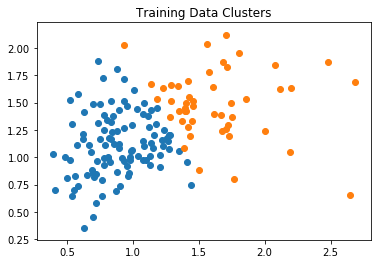

Number of Validation Features to cluster for this split: 10
Number of Validation Keys: 10


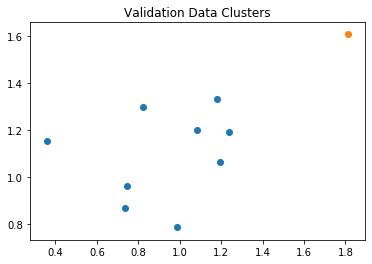

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:38:33] Training done on tvsum_aug. F-score: 0.6116


Score of this split 0.6242293169413997


In [39]:
_ = runTraining("multi",passed_splits="../splits/tvsum_aug.yml", base="GRU")

#### Transfer Setting

[2022/04/23 23:38:34] {'model': 'basic', 'device': 'cuda', 'seed': 12345, 'splits': ['../splits/tvsum_trans.yml'], 'max_epoch': 20, 'model_dir': '../models/ab_basic', 'log_file': 'log.txt', 'lr': 5e-05, 'weight_decay': 1e-05, 'lambda_reg': 1.0, 'nms_thresh': 0.5, 'ckpt_path': None, 'sample_rate': 15, 'source': None, 'save_path': None, 'base_model': 'attention', 'num_head': 8, 'num_feature': 1024, 'num_hidden': 128, 'neg_sample_ratio': 2.0, 'incomplete_sample_ratio': 1.0, 'pos_iou_thresh': 0.6, 'neg_iou_thresh': 0.0, 'incomplete_iou_thresh': 0.3, 'anchor_scales': [4, 8, 16, 32], 'lambda_ctr': 1.0, 'cls_loss': 'focal', 'reg_loss': 'soft-iou', 'batchExtract': False, 'featureFormat': 'avg1024'}
[2022/04/23 23:38:34] Start training on tvsum_trans: split 0


Running in mode: multi
Running in Feature Mode: precomputed
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


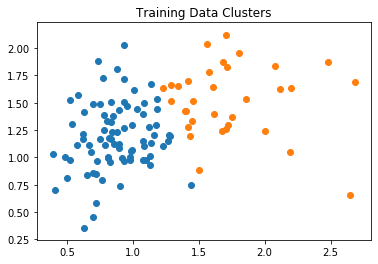

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


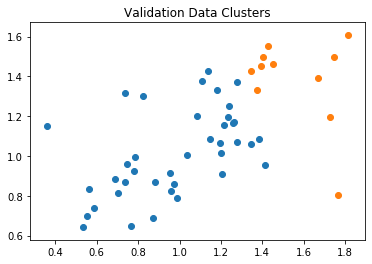

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:40:30] Start training on tvsum_trans: split 1


Score of this split 0.5732961442121842
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


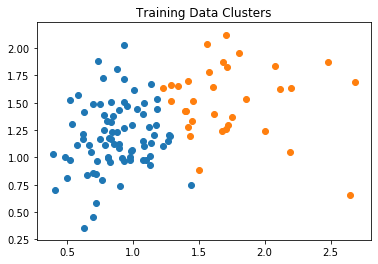

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


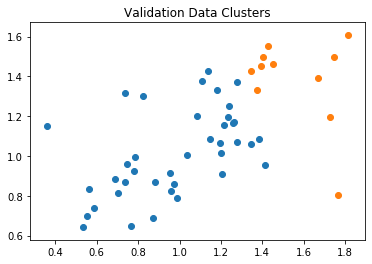

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:42:26] Start training on tvsum_trans: split 2


Score of this split 0.5740864202908997
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


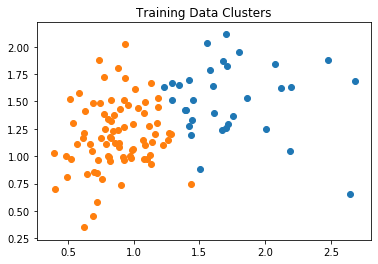

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


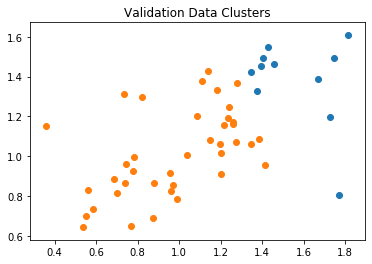

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:44:23] Start training on tvsum_trans: split 3


Score of this split 0.5797510873835554
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


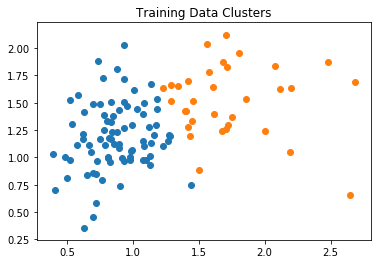

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


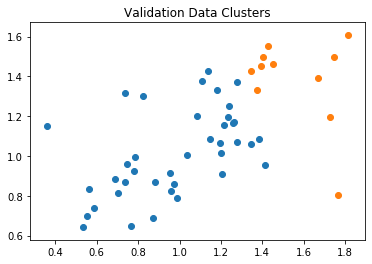

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:46:20] Start training on tvsum_trans: split 4


Score of this split 0.5722850120687956
Number of Training Features to cluster for this split: 114
Feature Shape: (2,)
Number of Training Keys: 114
Number of clusters: 2


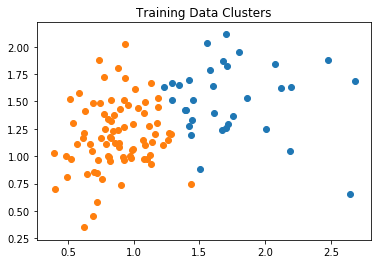

Number of Validation Features to cluster for this split: 50
Number of Validation Keys: 50


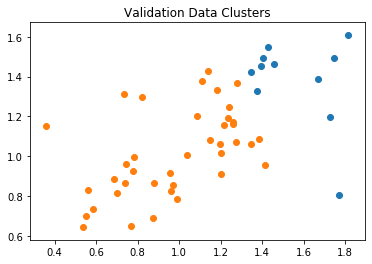

Models being used: {0: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
), 1: BasicGRU(
  (gru): GRU(1024, 128, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)}


[2022/04/23 23:48:17] Training done on tvsum_trans. F-score: 0.5749


Score of this split 0.5751150141052741


In [40]:
_ = runTraining("multi",passed_splits="../splits/tvsum_trans.yml", base="GRU")

# Representative Frame Visualisation

In this final section, we extract frames from the original videos we compare in our report. These frames are the centre frame of each keyshot predicted by our models and the ground truth keyshots for the video.

In [1]:
import cv2
import numpy as np

def read_frames(filename):
    video_cap = cv2.VideoCapture(filename)

    count = 0
    frames = []
    while True:
        success, frame = video_cap.read()

        if success:
            count += 1
            
            # convert from BGR to RGB format
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            frames.append(frame)
        else:
            # print('Failed to read frame') # when last frame read
            break;


    print('Read ', count, ' frames in total')
    video_cap.release()
    
    return frames

In [2]:
# path_to_summe_db = "../datasets/eccv16_dataset_summe_google_pool5.h5"
# path_to_tvsum_db = "../datasets/eccv16_dataset_tvsum_google_pool5.h5"
    
# Dataset contains filenames of videos
video_25_name = "playing_ball"
# Extracted from DB information file
video_24_name = "GsAD1KT1xo8"
video_42_name = "EYqVtI9YWJA"
    
data_dir = '../../../../2FPS_Videos/2FPS_SumMe/'
file_name = "2_fps_" + video_25_name + ".mp4"

frames_25 = read_frames(data_dir + file_name)

data_dir = '../../../../2FPS_Videos/2FPS_TVSum/video/'
file_name = "2_fps_" + video_24_name + ".mp4"

frames_24 = read_frames(data_dir + file_name)

data_dir = '../../../../2FPS_Videos/2FPS_TVSum/video/'
file_name = "2_fps_" + video_42_name + ".mp4"

frames_42 = read_frames(data_dir + file_name)

Read  208  frames in total
Read  291  frames in total
Read  397  frames in total


In [3]:
def showStoryBoard(frames, targets, figsize=(10,1), row_size=None, save=None):
    
    num_targets = len(targets)
    
    # Can specify if the plot should be split into rows of a certain size
    if row_size is not None:
        num_cols = np.round(num_targets / row_size)
    else:
        num_cols = 1
        row_size = num_targets
    
    plt.figure(figsize=figsize)
    for i, frame_idx in enumerate(targets):
        
        # No ticks, but axis still present
        plt.subplot(num_cols,row_size,i+1)
        plt.gca().tick_params(
            axis='both',       
            which='both',      
            bottom=False,      
            top=False,    
            left=False,
            right=False,
            labelbottom=False,
            labelleft=False)
        plt.imshow(frames[frame_idx])
        plt.title("Frame " + str(frame_idx))

    plt.tight_layout()
    
    if save is not None:
        plt.savefig(save, bbox_inches='tight')
        
    plt.show()

### Video 25 of SumMe

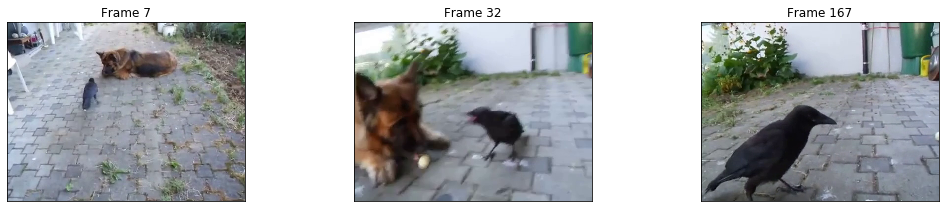

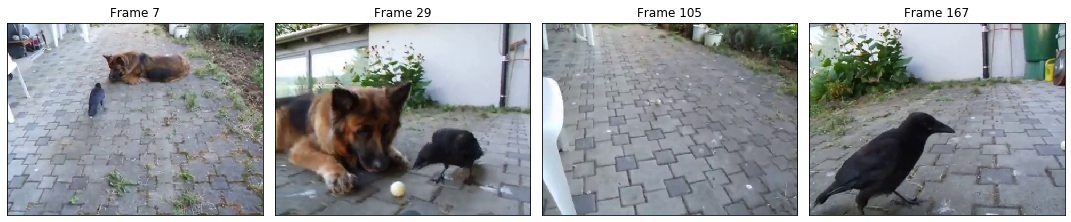

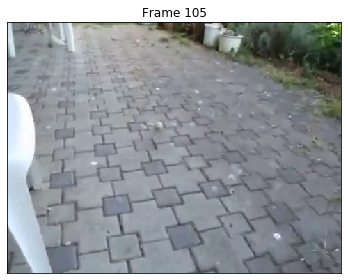

In [6]:
showStoryBoard(frames_25,[7,32,167],figsize=(15,3),
               save="./example_frames/video_25_gt")
showStoryBoard(frames_25,[7,29,105,167],figsize=(15,3),
               save="./example_frames/video_25_ours")

# Querying some frames
showStoryBoard(frames_25,[105],figsize=(20,4),
               save="./example_frames/video_25_extras")

### Video 24 of TVSum

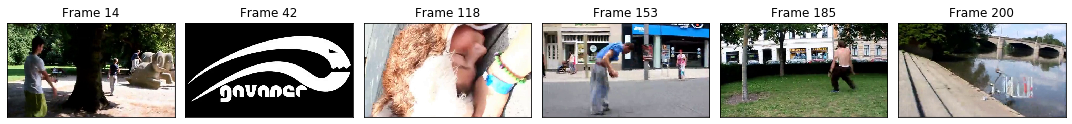

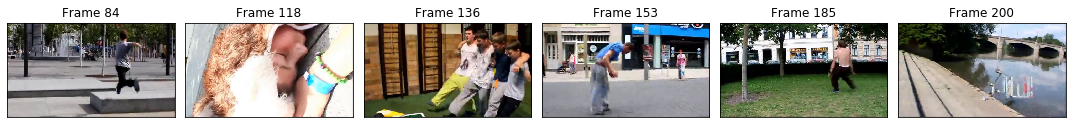

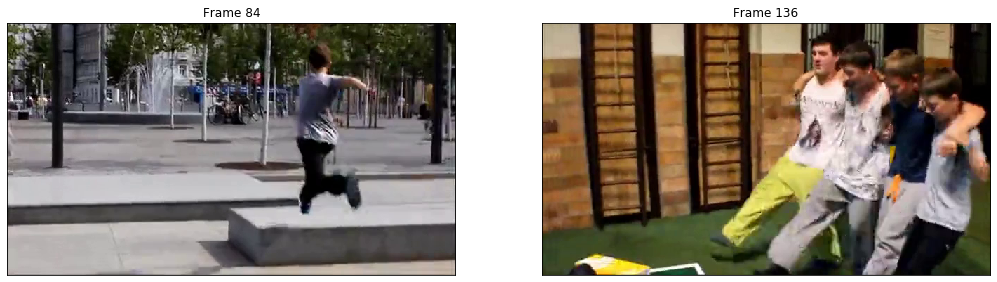

In [109]:
showStoryBoard(frames_24,[14,42,118,153,185,200],figsize=(15,3),
               save="./example_frames/video_24_gt")
showStoryBoard(frames_24,[84,118,136,153,185,200],figsize=(15,3),
               save="./example_frames/video_24_ours")

# Querying some frames
showStoryBoard(frames_24,[84,136],figsize=(15,4),
               save="./example_frames/video_24_extras")

### Video 42 of TVSum

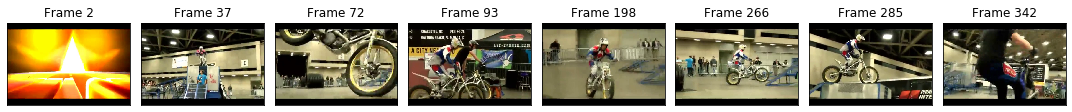

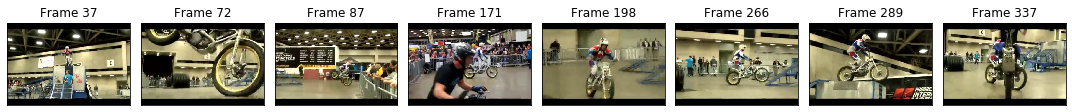

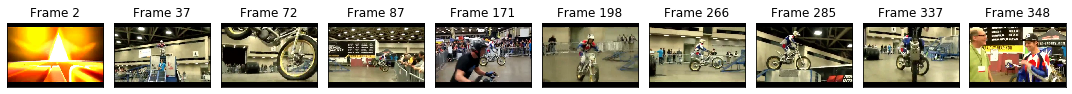

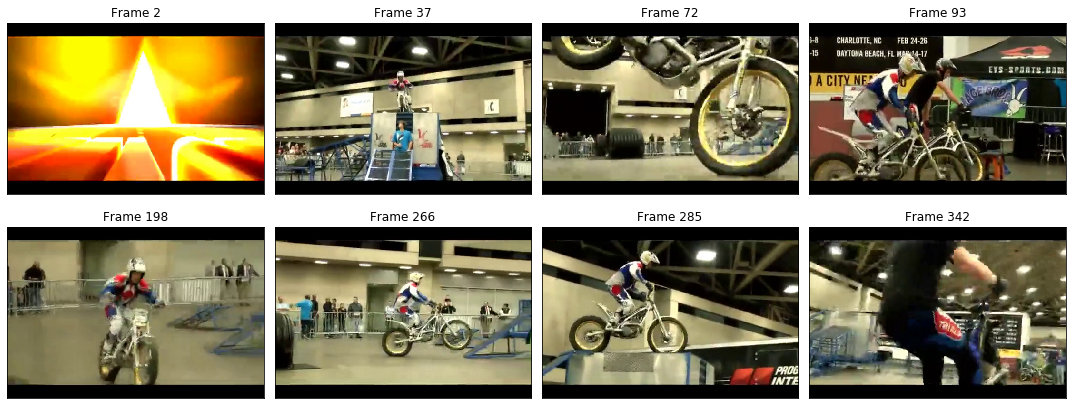

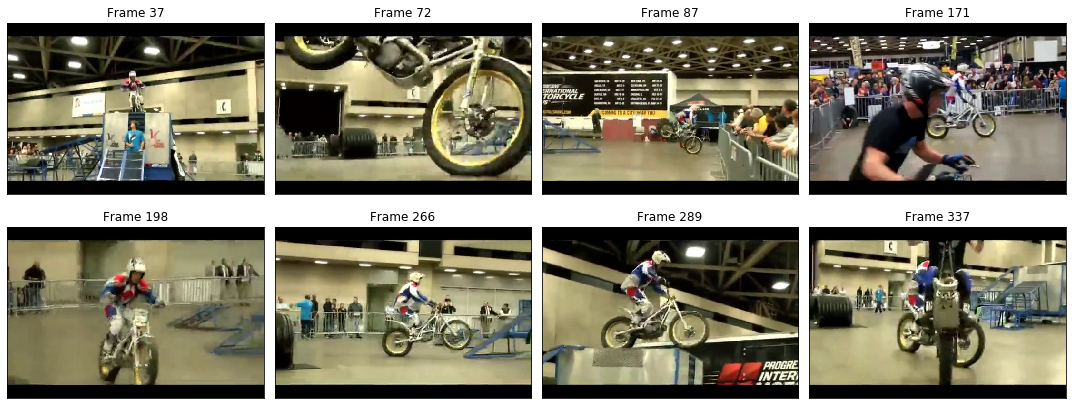

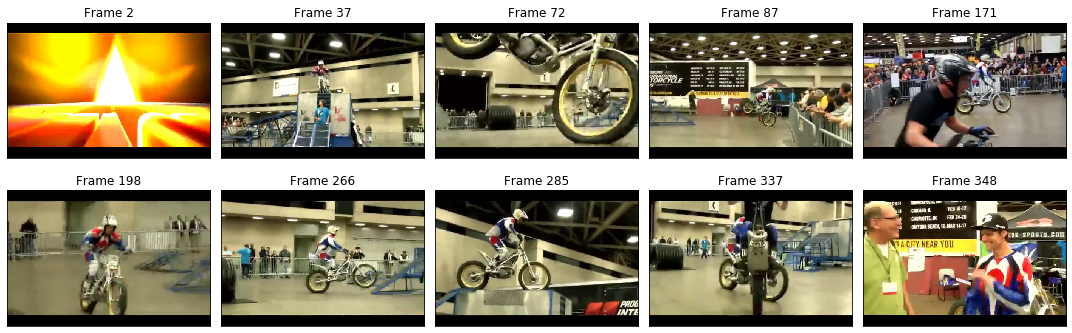

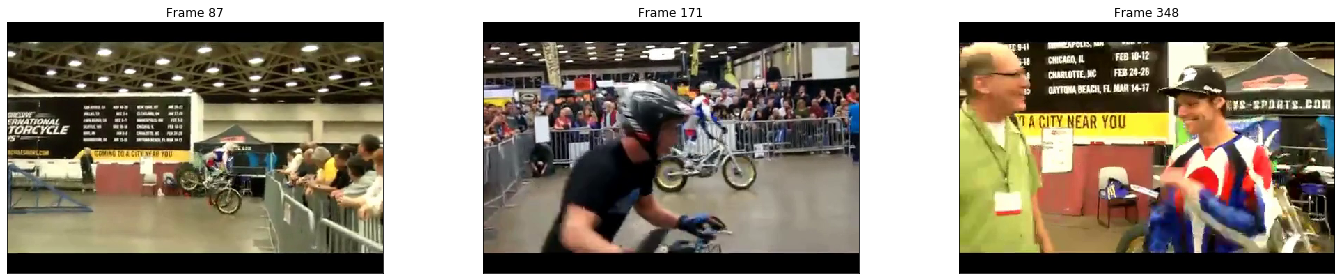

In [110]:
showStoryBoard(frames_42,[2,37,72,93,198,266,285,342],figsize=(15,3),
               save="./example_frames/video_42_gt")
showStoryBoard(frames_42,[37,72,87,171,198,266,289,337],figsize=(15,3),
               save="./example_frames/video_42_ours_single")
showStoryBoard(frames_42,[2,37,72,87,171,198,266,285,337,348],figsize=(15,3),
               save="./example_frames/video_42_ours_multi")

# Shows larger versions of the images, since split into 2 rows of 5
showStoryBoard(frames_42,[2,37,72,93,198,266,285,342],figsize=(15,6),
               save="./example_frames/video_42_gt_rows",row_size=4)
showStoryBoard(frames_42,[37,72,87,171,198,266,289,337],figsize=(15,6),
               save="./example_frames/video_42_ours_single_rows",row_size=4)
showStoryBoard(frames_42,[2,37,72,87,171,198,266,285,337,348],figsize=(15,5),
               save="./example_frames/video_42_ours_multi_rows",row_size=5)

# Querying some frames
showStoryBoard(frames_42,[87,171,348],figsize=(20,4),
               save="./example_frames/video_42_extras")
